In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
plt.rcParams["figure.dpi"] = 300

In [3]:
def memory(exp):
    memory_pd = pd.read_csv("stats" + f"/{exp}" + "/memory", header=None, delimiter=r"\s+")
    memory_pd.rename(columns = {0:'Time_s', 1:'GB used'}, inplace = True)
    first_time = memory_pd['Time_s'][0]
    memory_pd['Time_s'] = memory_pd['Time_s'].map(lambda x: x-first_time)
    #memory_pd = memory_pd.iloc[:3200, :]
    memory_pd['GB used'] = memory_pd['GB used'].map(lambda x: x/1024)
    memory_pd.plot(x='Time_s', y='GB used', kind = 'line')
    plt.savefig(f"graphs/mem_{exp}.png")
    

In [41]:
def memory_diff(exps):
    plt.figure()
    for exp in exps:
        memory_pd = pd.read_csv("stats" + f"/{exp}" + "/memory", header=None, delimiter=r"\s+")
        memory_pd.rename(columns = {0:'Time_s', 1:f"{exp} used"}, inplace = True)
        first_time = memory_pd['Time_s'][0]
        memory_pd['Time_s'] = memory_pd['Time_s'].map(lambda x: x-first_time)
        #memory_pd = memory_pd.iloc[:3200, :]
        memory_pd[f"{exp} used"] = memory_pd[f"{exp} used"].map(lambda x: x/1024)
        plt.plot(memory_pd['Time_s'], memory_pd[f"{exp} used"], label=f"{exp}")
    plt.xlabel("Time (s)")
    plt.ylabel("GB")
    plt.ylim(0,31)
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    #plt.show()
    plt.grid(alpha=0.3)

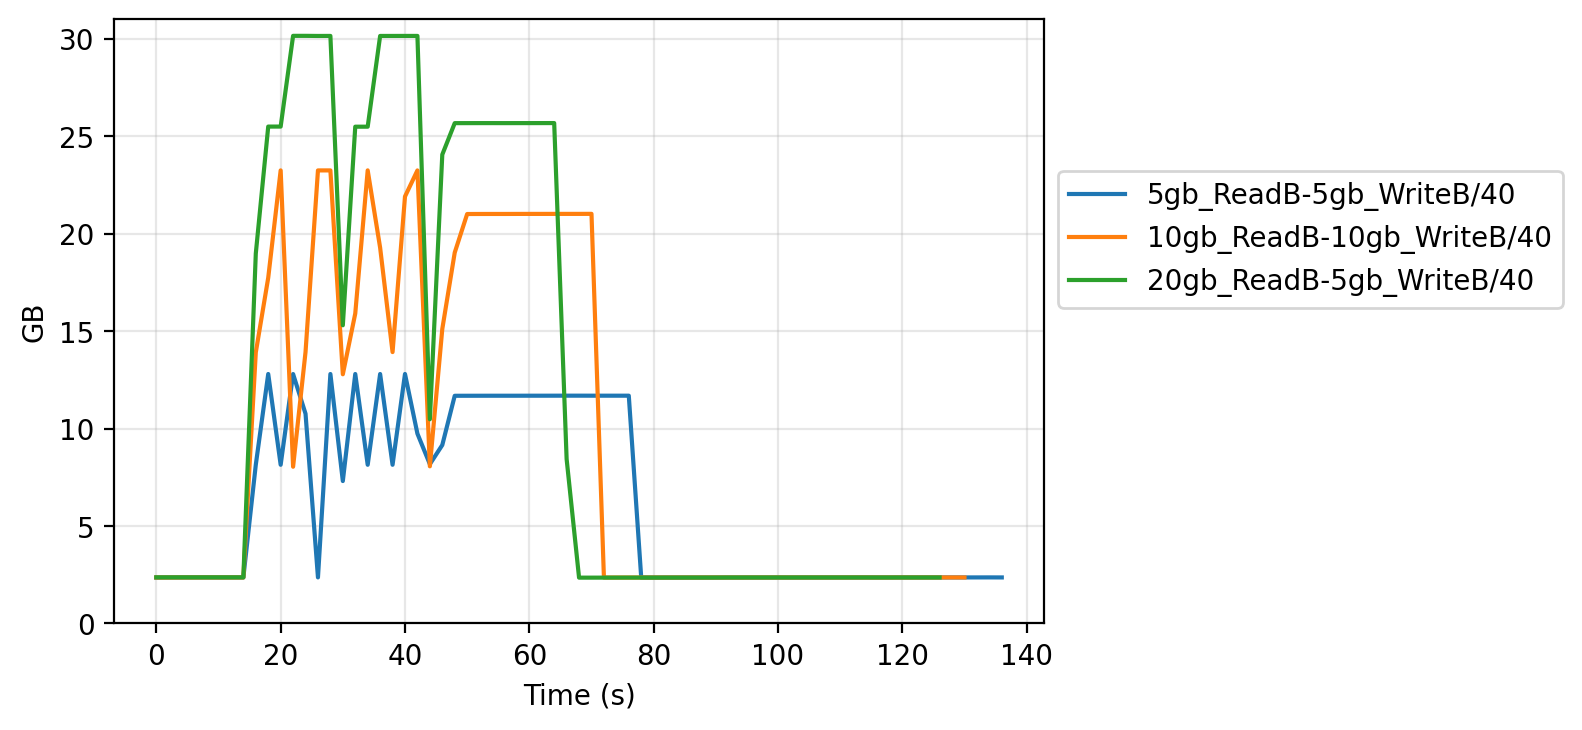

In [59]:
#memory_diff(['80/CEMS','80/WiscSort'])
memory_diff(['5gb_ReadB-5gb_WriteB/40','10gb_ReadB-10gb_WriteB/40','20gb_ReadB-5gb_WriteB/40'])
# memory_diff(['No_WriteB/40/WiscSort','5gb_ReadB-5gb_WriteB/40/WiscSort','10gb_WriteB/40/WiscSort','20gb_WriteB/40/WiscSort'])
# memory_diff(['No_WriteB/40', '5gb_WriteB/40', '10gb_WriteB/40', '20gb_WriteB/40'])

In [ ]:
def disk(exp):
    iostat_pd = pd.read_csv("stats" + f"/{exp}" + "/iostats", header=None, delimiter=r"\s+")
    iostat_pd.rename(columns = {0:"Time_s", 5:"MB_read", 6:"MB_wrtn"}, inplace=True)
    iostat_pd.drop([1,2,3,4],1, inplace=True)
    iostat_pd = iostat_pd.iloc[2:]
    first_time = iostat_pd['Time_s'][2]
    iostat_pd['Time_s'] = iostat_pd['Time_s'].map(lambda x: x-first_time)
    #iostat_pd = iostat_pd.iloc[2:3500:, :] #dropping first 2 rows as this can be random.
    ax = plt.gca()
    iostat_pd.plot(kind = 'line', x='Time_s', y='MB_read', color='red', ax=ax, label="Read")
    plt.axhline(y=3500, color='red', linestyle='--', label="Max read")
    iostat_pd.plot(kind = 'line', x='Time_s', y='MB_wrtn', color='black', ax=ax, label="Write")
    plt.axhline(y=2700, color='black', linestyle='--', label="Max write")
    plt.xlabel("Time (s)")
    plt.title(f"{exp}")
    plt.ylabel("MB/s")
    plt.yticks(np.arange(0, 3800, step=200))
    plt.xticks(np.arange(0, 380, step=40))
    # plt.xlim(-1, 350)
    
    # Run and merge stage indicators
    data = run_stats(exp)
    run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['Total RUN']
    merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE']
    plt.axvspan(9, 12 + run_time, color='orange', alpha=0.2, label = "RUN")
    plt.axvspan(12 + run_time, 12 + run_time + merge_time +2 , color='cornflowerblue', alpha=0.2, label = "MERGE")
    
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    plt.grid(alpha=0.2)
    plt.show()

In [ ]:
disk("nvme/40gb_10k_4086v/CEMS")
disk("nvme/40gb_10k_4086v/WiscSort_NoWB")
disk("nvme/40gb_10k_4086v/WiscSort")

In [6]:
def disk_write_cdf_diff(node_num, exp, node_num_1, exp_1):
    iostat_pd = pd.read_csv("collected/node"+f"{node_num}"+ f"/{exp}/{exp}" + "/iostats", header=None, delimiter=r"\s+")
    iostat_pd.rename(columns = {0:"Time_s", 5:"MB_read", 6:"MB_wrtn"}, inplace=True)
    iostat_pd.drop([1,2,3,4],1, inplace=True)
    iostat_pd = iostat_pd.iloc[2:]
    # normalizing time
    first_time = iostat_pd['Time_s'][2]
    iostat_pd['Time_s'] = iostat_pd['Time_s'].map(lambda x: x-first_time)
    cdf_wrtn = iostat_pd['MB_wrtn'].value_counts().sort_index().cumsum() / iostat_pd['MB_wrtn'].shape[0]
    #cdf_read = iostat_pd['MB_read'].value_counts().sort_index().cumsum() / iostat_pd['MB_read'].shape[0]
    iostat_pd_1 = pd.read_csv("collected/node"+f"{node_num_1}"+ f"/{exp_1}/{exp_1}" + "/iostats", header=None, delimiter=r"\s+")
    iostat_pd_1.rename(columns = {0:"Time_s", 5:"MB_read", 6:"MB_wrtn"}, inplace=True)
    iostat_pd_1.drop([1,2,3,4],1, inplace=True)
    iostat_pd_1 = iostat_pd_1.iloc[2:]
    first_time_1 = iostat_pd_1['Time_s'][2]
    iostat_pd_1['Time_s'] = iostat_pd_1['Time_s'].map(lambda x: x-first_time_1)
    cdf_wrtn_1 = iostat_pd_1['MB_wrtn'].value_counts().sort_index().cumsum() / iostat_pd_1['MB_wrtn'].shape[0]
    #cdf_read = iostat_pd['MB_read'].value_counts().sort_index().cumsum() / iostat_pd['MB_read'].shape[0]
    plt.figure()
    ax = cdf_wrtn.plot(label="node0")
    ax = cdf_wrtn_1.plot(ax=ax, color='violet', label="node1")
    ax.set(xlabel='MB/s')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"graphs/disk_write_cdf_{exp}_{exp_1}.png")

disk_write_cdf_diff(0,13,1,13)


FileNotFoundError: [Errno 2] No such file or directory: 'collected/node0/13/13/iostats'

In [7]:
def disk_write_cdf(node_num, exp):
    iostat_pd = pd.read_csv("collected/node"+f"{node_num}"+ f"/{exp}/{exp}" + "/iostats", header=None, delimiter=r"\s+")
    iostat_pd.rename(columns = {0:"Time", 5:"MB_read", 6:"MB_wrtn"}, inplace=True)
    iostat_pd.drop([1,2,3,4],1, inplace=True)
    iostat_pd = iostat_pd.iloc[2:]
    cdf_wrtn = iostat_pd['MB_wrtn'].value_counts().sort_index().cumsum() / iostat_pd['MB_wrtn'].shape[0]
    cdf_read = iostat_pd['MB_read'].value_counts().sort_index().cumsum() / iostat_pd['MB_read'].shape[0]
    plt.figure()
    ax = cdf_wrtn.plot(label="wrtn_MB")
    ax = cdf_read.plot(ax=ax, color='red', label="read_MB")
    ax.set(xlabel='MB/s')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"graphs/disk_write_cdf_{exp}.png")
    
disk_write_cdf(0, 7)

FileNotFoundError: [Errno 2] No such file or directory: 'collected/node0/7/7/iostats'

In [8]:
def tmp_size(node_num, exp):
    tmp_pd = pd.read_csv("collected/node"+f"{node_num}"+ f"/{exp}/{exp}" + "/tmp_folder_size", header=None, delimiter=r"\s+")
    tmp_pd.rename(columns = {0:'Time', 1:'GB used'}, inplace=True)
    #tmp_pd = tmp_pd.iloc[:1500, :]
    tmp_pd['GB used'] = tmp_pd['GB used'].map(lambda x: x/1024)
    plt.figure()
    tmp_pd.plot(x='Time', y='GB used', kind = 'line', title=f"Node {node_num} /tmp usage", color='green')
    plt.savefig(f"tmp_size_{exp}.png")

In [9]:
for i in range(1):
#     tmp_size(i,51)
#     tmp_size(i,55)
#     tmp_size(i,56)
#     tmp_size(i,58)
    tmp_size(1,60)

FileNotFoundError: [Errno 2] No such file or directory: 'collected/node1/60/60/tmp_folder_size'

In [10]:
def net_usage(interface, node_num, exp):
    net0_pd = pd.read_csv("collected/node"+f"{node_num}"+ f"/{exp}/{exp}" + f"/nw.{interface}", header=None, delimiter=r"\s+")
    net0_pd.rename(columns = {0:'Time_s', 1:'recv_MB', 2:'sent_MB'}, inplace = True) 
    first_time = net0_pd['Time_s'][0]
    net0_pd['Time_s'] = net0_pd['Time_s'].map(lambda x: x-first_time)
    net0_pd['recv_MB'] = net0_pd['recv_MB'].map(lambda x: x/(1024*1024))
    net0_pd['sent_MB'] = net0_pd['sent_MB'].map(lambda x: x/(1024*1024))
    net0_pd = net0_pd.iloc[:3000, :]
    ax = plt.gca()
    net0_pd.plot(kind = 'line', x='Time_s', y='recv_MB', color='red', ax=ax, title=f"Node {node_num} net-{interface} usage")
    net0_pd.plot(kind = 'line', x='Time_s', y='sent_MB', ax=ax)
    #ax.set_yscale('log')
    #plt.show()
    plt.savefig(f"graphs/net_usage_{exp}.png")
    

for i in range(1):
    net_usage(0, 0, 13)
#     net_usage(0, i, 55)
#     net_usage(0, i, 56)
#     net_usage(0, i, 58)
    #net_usage(1, i, 51)

FileNotFoundError: [Errno 2] No such file or directory: 'collected/node0/13/13/nw.0'

In [11]:
def net_diff(interface, node_num, exp, interface_1, node_num_1, exp_1):
    net0_pd = pd.read_csv("collected/node"+f"{node_num}"+ f"/{exp}/{exp}" + f"/nw.{interface}", header=None, delimiter=r"\s+")
    net0_pd.rename(columns = {0:'Time_s', 1:f"recv_MB {exp}", 2:f"sent_MB {exp}"}, inplace = True)
    net0_pd[f"recv_MB {exp}"] = net0_pd[f"recv_MB {exp}"].map(lambda x: x/(1024*1024))
    net0_pd[f"sent_MB {exp}"] = net0_pd[f"sent_MB {exp}"].map(lambda x: x/(1024*1024))
    #net0_pd = net0_pd.iloc[:3000, :]
    net0_pd_1 = pd.read_csv("collected/node"+f"{node_num_1}"+ f"/{exp_1}/{exp_1}" + f"/nw.{interface_1}", header=None, delimiter=r"\s+")
    net0_pd_1.rename(columns = {0:'Time_s', 1:f"recv_MB {exp_1}", 2:f"sent_MB {exp_1}"}, inplace = True) 
    net0_pd_1[f"recv_MB {exp_1}"] = net0_pd_1[f"recv_MB {exp_1}"].map(lambda x: x/(1024*1024))
    net0_pd_1[f"sent_MB {exp_1}"] = net0_pd_1[f"sent_MB {exp_1}"].map(lambda x: x/(1024*1024))
    
    net0_pd_1['Time_s'] = net0_pd['Time_s']
    # Normalize time
    first_time = net0_pd['Time_s'][0]
    net0_pd['Time_s'] = net0_pd['Time_s'].map(lambda x: x-first_time)
    first_time_1 = net0_pd_1['Time_s'][0]
    net0_pd_1['Time_s'] = net0_pd_1['Time_s'].map(lambda x: x-first_time_1)
    
    plt.figure()
    plt.plot(net0_pd['Time_s'], net0_pd[f"recv_MB {exp}"], color='red', label="recv_MB node0")
    plt.plot(net0_pd['Time_s'], net0_pd[f"sent_MB {exp}"], label="sent_MB node0")
    plt.plot(net0_pd_1['Time_s'], net0_pd_1[f"recv_MB {exp_1}"], label="recv_MB node1")
    plt.plot(net0_pd_1['Time_s'], net0_pd_1[f"sent_MB {exp_1}"], label="sent_MB node1")
#     plt.yscale('log')
    plt.legend()
    plt.yticks(np.arange(0, 250, step=25))
    #plt.show()
    plt.grid()
    plt.xlabel("Time (s)")
    plt.ylabel("MB")
    plt.savefig(f"graphs/net_{exp}_{exp_1}.png")

net_diff(0,0,16,0,1,16)

FileNotFoundError: [Errno 2] No such file or directory: 'collected/node0/16/16/nw.0'

In [12]:
# TODO: Plot total sent and recieved across various experiments
def total_net_data(interface, node_num, exp):
    net0_pd = pd.read_csv("collected/node"+f"{node_num}"+ f"/{exp}/{exp}" + f"/nw.{interface}", header=None, delimiter=r"\s+")
    net0_pd.rename(columns = {0:'Time', 1:f"recv_MB {exp}", 2:f"sent_MB {exp}"}, inplace = True)
    net0_pd[f"recv_MB {exp}"] = net0_pd[f"recv_MB {exp}"].map(lambda x: x/(1024*1024))
    net0_pd[f"sent_MB {exp}"] = net0_pd[f"sent_MB {exp}"].map(lambda x: x/(1024*1024))
    total_sent = 0
    total_recv = 0
    for index, row in net0_pd.iterrows():
        total_recv += row[f"recv_MB {exp}"]
        total_sent += row[f"sent_MB {exp}"]
    print("Total sent: ", total_sent)
    print("Total recv: ", total_recv)

total_net_data(0,0,13)

FileNotFoundError: [Errno 2] No such file or directory: 'collected/node0/13/13/nw.0'

In [57]:
def cpu_usage(exp):
    cpu_pd = pd.read_csv("stats/"+ f"{exp}" + "/cpu", header=[0], delimiter=r",",  skiprows=5)
    first_time = cpu_pd['epoch'][0]
    cpu_pd['epoch'] = cpu_pd['epoch'].map(lambda x: x-first_time)
    cpu_pd['total'] = cpu_pd.apply(lambda x: x['usr'] + x['sys'], axis=1)
    plt.figure()
    plt.plot(cpu_pd['epoch'], cpu_pd['usr'], lw=2, label = "usr")
    plt.plot(cpu_pd['epoch'], cpu_pd['sys'], lw=2, label = "sys")
    plt.plot(cpu_pd['epoch'], cpu_pd['wai'], lw=2, label = "wait", color='red')
    plt.fill_between(cpu_pd['epoch'], cpu_pd['total'], color='green', alpha=.3, label = "total")
    plt.yticks(np.arange(0, 101, step=10))
    plt.xticks(np.arange(0, 100, step= 10))
    plt.legend()
    plt.grid()
    plt.xlabel("Time (s)")
    plt.ylabel("CPU utilization (%)")

def cpu_usage_diff(exps):
    plt.figure()
    for exp in exps:
        cpu_pd = pd.read_csv("stats/"+ f"{exp}" + "/cpu", header=[0], delimiter=r",",  skiprows=5)
        first_time = cpu_pd['epoch'][0]
        cpu_pd['epoch'] = cpu_pd['epoch'].map(lambda x: x-first_time)
        cpu_pd['total'] = cpu_pd.apply(lambda x: x['usr'] + x['sys'], axis=1)
        plt.plot(cpu_pd['epoch'], cpu_pd['total'],label = f"{exp}")
    #plt.yticks(np.arange(0, 101, step=10))
    plt.legend()
    plt.grid()
    plt.xlabel("Time (s)")
    plt.ylabel("CPU utilization (%)")    

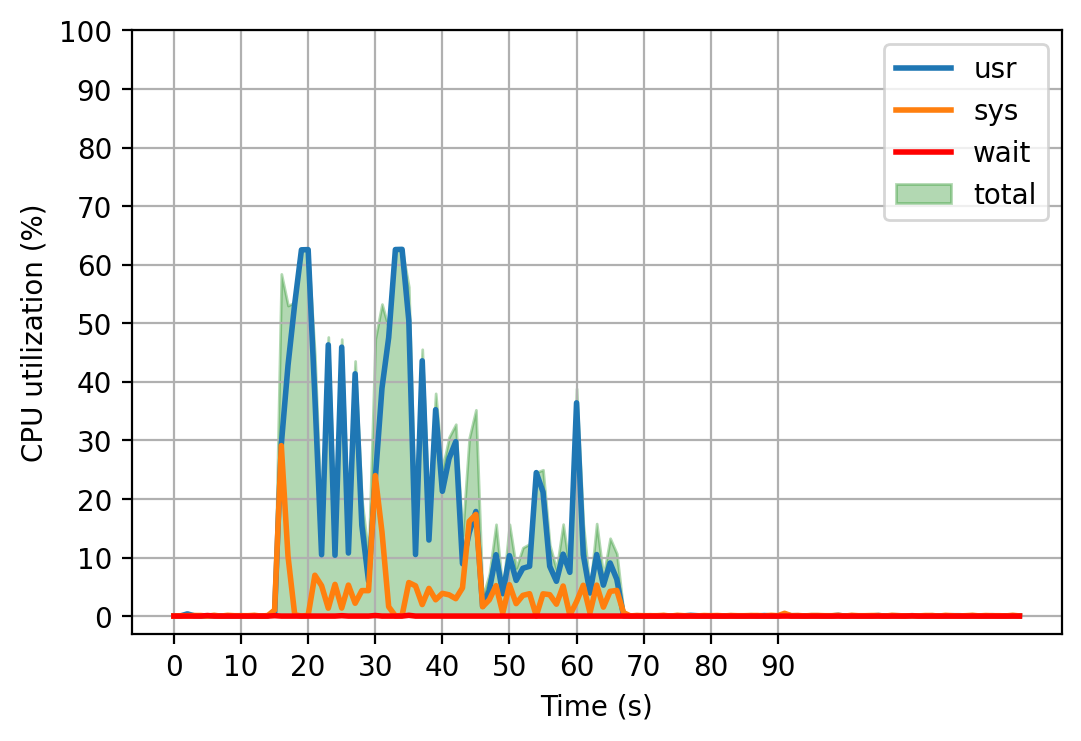

In [58]:
#cpu_usage('old/20/EmsPmdkWrite')
cpu_usage('20gb_ReadB-5gb_WriteB/40')
# cpu_usage('80/WiscSort')
#cpu_usage_diff(['EmsPmdkWrite100G','GammaPmdkWrite100Gv1','GammaPmdkWrite100Gv2','EmsPmdkWrite100G'])

In [15]:
def anti_cpu_usage(node_num, exp):
    cpu_pd = pd.read_csv("collected/node"+f"{node_num}"+ f"/{exp}/{exp}" + "/cpu", header=[0], delimiter=r",",  skiprows=5)
    first_time = cpu_pd['epoch'][0]
    cpu_pd['epoch'] = cpu_pd['epoch'].map(lambda x: x-first_time)
    cpu_pd['total'] = cpu_pd.apply(lambda x: x['idl'] + x['wai'], axis=1)
    plt.figure()
    plt.plot(cpu_pd['epoch'], cpu_pd['idl'], lw=2, label = "idl")
    plt.plot(cpu_pd['epoch'], cpu_pd['wai'], lw=2, label = "wai")
    plt.fill_between(cpu_pd['epoch'], cpu_pd['total'], color='red', alpha=.3, label = "total")
    plt.yticks(np.arange(0, 100, step=10))
    plt.legend()
    plt.grid()
    print(cpu_pd)
anti_cpu_usage(0,9)

FileNotFoundError: [Errno 2] No such file or directory: 'collected/node0/9/9/cpu'

In [16]:
'''
S0-iMC0.PMM_BW_READS_KAN
|     S0-iMC1.PMM_BW_READS_KAN
|     |     S0-iMC2.PMM_BW_READS_KAN
|     |     |     S0-iMC3.PMM_BW_READS_KAN
|     |     |     |     S0-iMC4.PMM_BW_READS_KAN
|     |     |     |     |     S0-iMC5.PMM_BW_READS_KAN
|     |     |     |     |     |     S0-iMC0.PMM_BW_WRITES_KAN
|     |     |     |     |     |     |     S0-iMC1.PMM_BW_WRITES_KAN
|     |     |     |     |     |     |     |     S0-iMC2.PMM_BW_WRITES_KAN
|     |     |     |     |     |     |     |     |     S0-iMC3.PMM_BW_WRITES_KAN
|     |     |     |     |     |     |     |     |     |     S0-iMC4.PMM_BW_WRITES_KAN
|     |     |     |     |     |     |     |     |     |     |     S0-iMC5.PMM_BW_WRITES_KAN
'''
def pmem_bandwdith(exp):
    pmem_pd = pd.read_csv("stats/"+ f"{exp}" + "/pmem", header=[0], delimiter=r",", skipfooter=35, engine='python')
    pm_df = pd.DataFrame(columns = ['time', 'read_bw', 'write_bw'])
    for index, row in pmem_pd.iterrows():
        total_read_bw = 0
        total_write_bw = 0
        for read in row[1:7]:
            total_read_bw += read
        for write in row[7:]:
            total_write_bw += write
        pm_df = pm_df.append({'time': row['timestamp'], 'read_bw': total_read_bw, 'write_bw':total_write_bw}, ignore_index=True)
    
    with open("stats/"+f"{exp}" + "/splits", newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    print(data)
    
    plt.figure()
    plt.plot(pm_df['time'], pm_df['read_bw'], color='red', label="read_bw")
    plt.plot(pm_df['time'], pm_df['write_bw'], color='blue', label="write_bw")
    plt.grid(alpha=0.2)
    plt.xlabel("Time (s)")
    plt.ylabel("PMEM bandwdith (GB/s)")
    plt.title(exp)
    plt.xticks(np.arange(0, 150, step=10))
    xs = np.linspace(1, 1.5, 4)
    plt.vlines(x=[float(x) for x in data[0]], ymin=0, ymax=len(xs), colors='indianred', ls='--', lw=2, label='RREAD')
    plt.vlines(x=[float(x) for x in data[2]], ymin=0, ymax=len(xs), colors='cornflowerblue', ls='--', lw=2, label='RWRITE')
    plt.vlines(x=[float(x) for x in data[3]], ymin=0, ymax=len(xs), colors='indianred', ls=':', lw=2, label='MREAD')
    plt.vlines(x=[float(x) for x in data[4]], ymin=0, ymax=len(xs), colors='cornflowerblue', ls=':', lw=2, label='MWRITE')    
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
    
# pmem_bandwdith('40gAlpha')
# pmem_bandwdith('40gEMS')
# pmem_bandwdith('100gBeta')

In [17]:
pmem_bandwdith('single_thread_exp/EmsPmdkWrite')

FileNotFoundError: [Errno 2] No such file or directory: 'stats/single_thread_exp/EmsPmdkWrite/pmem'

In [38]:
def run_stats(exp):
    results = pd.read_csv("stats/"+f"{exp}" + "/results", delimiter=r":", header = None)
    begin = 0
    for idx, row in results.iterrows():
        if row[0].startswith("="):
            begin = idx+1
    results = results[begin:]
    data = {}
    for index, row in results.iterrows():
        data[f'{row[0].strip()}'] = row[1]
    if 'Total RUN' in data:
        data['Total RUN'] -= (data['RUN read'] + data['RUN sort'] + data['RUN write'])
    if 'Total MERGE' in data:
        data['Total MERGE'] -= (data['MERGE read'] + data['MERGE write'])
    else:
        data['Total MERGE'] = 0
        data['MERGE read'] = 0
        data['MERGE write'] = 0
    return data

def spl_pmem_bandwdith(exp):
    pmem_pd = pd.read_csv("stats/"+ f"{exp}" + "/pmem", header=[0], delimiter=r",", engine='python')
    pm_df = pd.DataFrame(columns = ['time', 'read_bw', 'write_bw'])
    for index, row in pmem_pd.iterrows():
        total_read_bw = 0
        total_write_bw = 0
        for read in row[1:7]:
            total_read_bw += float(read)
        for write in row[7:]:
            total_write_bw += float(write)
        pm_df = pm_df.append({'time': row['timestamp'], 'read_bw': total_read_bw, 'write_bw':total_write_bw}, ignore_index=True)
    
    plt.figure()
    plt.xticks(np.arange(0, 300, step=0.10))
    plt.yticks(np.arange(0, 30.5, step=2))
    plt.ylim(-0.1, 30.5)
    plt.xlim(-0.5, 100)
    plt.plot(pm_df['time'], pm_df['read_bw'], color='red', label="read bw")
    # Max read bandwidth
    plt.axhline(y=25, color='r', linestyle='--', label="Max read bw")
    plt.plot(pm_df['time'], pm_df['write_bw'], color='black', label="write bw")
    # Max write bandwidth
    plt.axhline(y=6.9, color='black', linestyle='--', label="Max write bw")
    plt.grid(alpha=0.2)
    
    # Run and merge stage indicators
    data = run_stats(exp)
    run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['Total RUN']
    merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE']
    plt.axvspan(9.4, 12 + run_time, color='orange', alpha=0.2, label = "RUN")
    plt.axvspan(12 + run_time, 12 + run_time + merge_time, color='cornflowerblue', alpha=0.2, label = "MERGE")
    plt.xlabel("Time (s)")
    # plt.ylabel("PMEM bandwdith (GB/s)")
    plt.title(exp)

    # plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

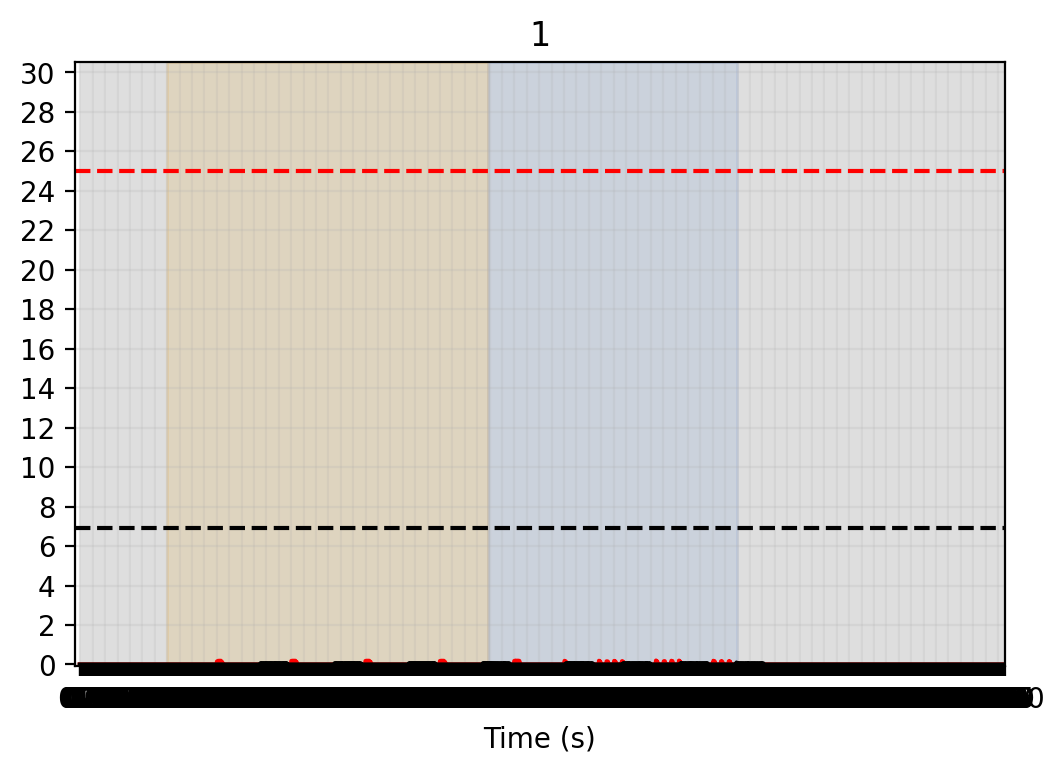

In [39]:
# spl_pmem_bandwdith('5gb_ReadB-5gb_WriteB/40/CEMS')
# spl_pmem_bandwdith('10gb_ReadB-10gb_WriteB/40/CEMS')
# spl_pmem_bandwdith('20gb_ReadB-5gb_WriteB/40/CEMS')
#spl_pmem_bandwdith('5gb_ReadB-5gb_WriteB/80/CEMS')
# spl_pmem_bandwdith("VKratio/250_6/WiscSort")
# spl_pmem_bandwdith("VKratio/200_56/WiscSort")
# spl_pmem_bandwdith("VKratio/150_106/WiscSort")
# spl_pmem_bandwdith('100Gib_256R')
# spl_pmem_bandwdith('200Gib_512R')
# spl_pmem_bandwdith('No_WriteB/40/WiscSort')
# spl_pmem_bandwdith('20gb_WriteB/40/WiscSort')
# spl_pmem_bandwdith('10gb_WriteB/40/WiscSort')
# spl_pmem_bandwdith('5gb_ReadB-5gb_WriteB/40/WiscSort')
# spl_pmem_bandwdith('5gb_ReadB-5gb_WriteB/60/WiscSort')
# spl_pmem_bandwdith('5gb_ReadB-5gb_WriteB/80/WiscSort')
spl_pmem_bandwdith("1")

In [41]:
## Subplots of same graph
def run_stats(exp, sort):
    results = pd.read_csv("stats/VKratio/"+ f"{exp}/{sort}" + "/results", delimiter=r":", header = None)
    begin = 0
    for idx, row in results.iterrows():
        if row[0].startswith("="):
            begin = idx+1
    results = results[begin:]
    data = {}
    for index, row in results.iterrows():
        data[f'{row[0].strip()}'] = row[1]
    if 'Total RUN' in data:
        data['Total RUN'] -= (data['RUN read'] + data['RUN sort'] + data['RUN write'])
    if 'Total MERGE' in data:
        data['Total MERGE'] -= (data['MERGE read'] + data['MERGE write'])
    else:
        data['Total MERGE'] = 0
        data['MERGE read'] = 0
        data['MERGE write'] = 0
    return data
def pmem_bandwdith_subplots(exps,sort):
    fig,ax =  plt.subplots(2, len(exps)//2, sharex=True, sharey=True,)
    i = 0; # row
    j = 0; # column
    comp = (len(exps)//2)-1
    for idx,exp in enumerate(exps):
        pmem_pd = pd.read_csv("stats/VKratio/"+ f"{exp}/{sort}" + "/pmem", header=[0], delimiter=r",", engine='python')
        pm_df = pd.DataFrame(columns = ['time', 'read_bw', 'write_bw'])
        for index, row in pmem_pd.iterrows():
            total_read_bw = 0
            total_write_bw = 0
            for read in row[1:7]:
                total_read_bw += float(read)
            for write in row[7:]:
                total_write_bw += float(write)
            pm_df = pm_df.append({'time': row['timestamp'], 'read_bw': total_read_bw, 'write_bw':total_write_bw}, ignore_index=True)

        ax[i][j].set_xticks(np.arange(0, 300, step=10))
        ax[i][j].set_yticks(np.arange(0, 30.5, step=5))
        ax[i][j].set_ylim(-0.1, 30.5)
        ax[i][j].set_xlim(-0.5, 60)
        ax[i][j].plot(pm_df['time'], pm_df['read_bw'], color='red', label="read bw")
        # Max read bandwidth
        ax[i][j].axhline(y=25, color='r', linestyle='--', label="Max read bw")
        ax[i][j].plot(pm_df['time'], pm_df['write_bw'], color='black', label="write bw")
        # Max write bandwidth
        ax[i][j].axhline(y=6.9, color='black', linestyle='--', label="Max write bw")
        ax[i][j].grid(alpha=0.2)

        # Run and merge stage indicators
        data = run_stats(exp,sort)
        run_time = data['RUN read'] + data['RUN write'] + data['RUN sort'] + data['Total RUN']
        merge_time = data['MERGE read'] + data['MERGE write'] + data['Total MERGE']
        ax[i][j].axvspan(12, 13 + run_time, color='orange', alpha=0.2, label = "RUN")
        ax[i][j].axvspan(13 + run_time, 13 + run_time + merge_time + 5, color='cornflowerblue', alpha=0.2, label = "MERGE")
        ax[i][j].set_title(f"{exp.split('_')[1]}:{exp.split('_')[0]}")
        if idx < comp:
            j+=1
        else:
            i+= 1
            comp = (comp * 2)+1
            j = 0
    fig.text(0.5, 0.0, 'Time (s)', ha='center')
    fig.text(0.0, 0.5, 'PMEM bandwdith (GB/s)', va='center', rotation='vertical')            
    plt.tight_layout()

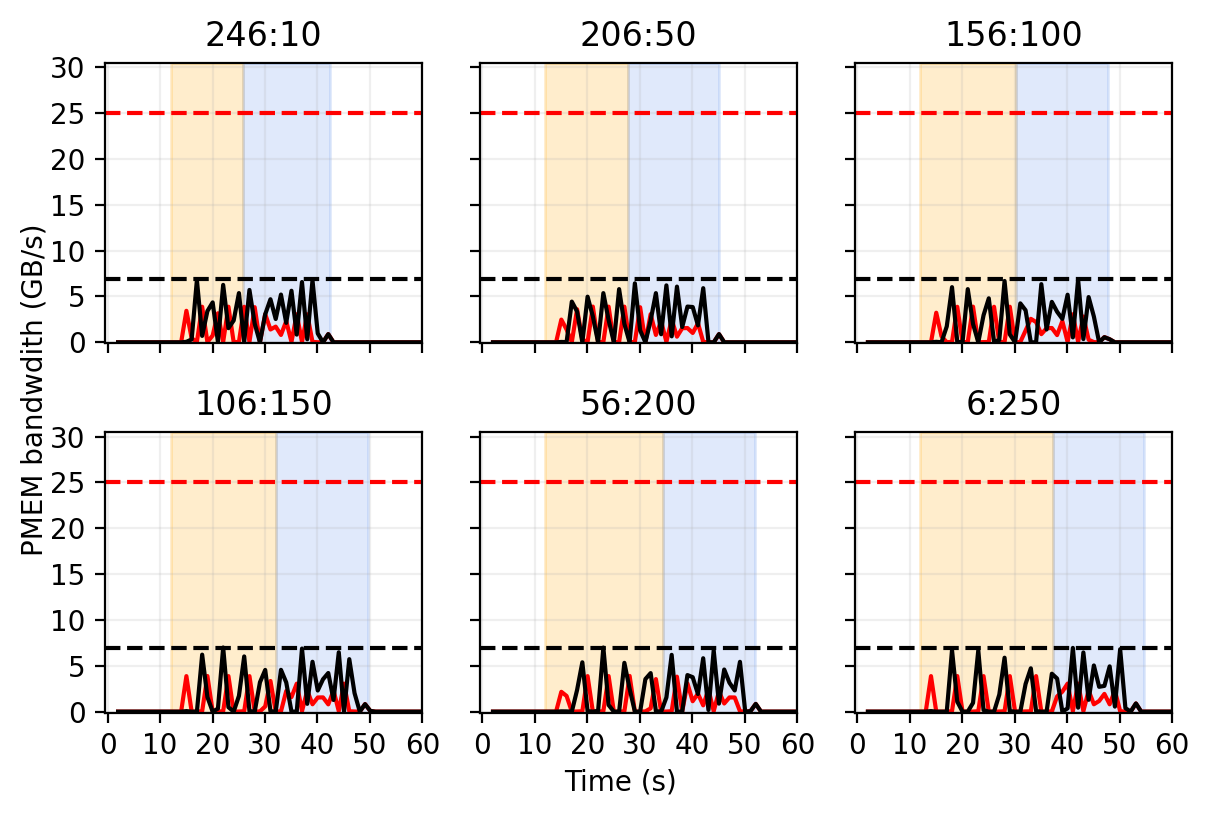

In [42]:
#pmem_bandwdith_subplots(['10_246', '50_206', '100_156', '150_106', '200_56', '250_6'], 'WiscSort')
pmem_bandwdith_subplots(['10_246', '50_206', '100_156', '150_106', '200_56', '250_6'], 'CEMS')

{'RUN read': [9.957921, 36.636933, 58.39124399999999], 'SORT': [29.764364, 56.480376], 'RUN write': [31.419552000000003, 58.134663], 'MERGE seq read': [58.974539, 59.577879], 'MERGE write': [124.72605300000001, 187.29448200000002]}
{'RUN read': [12.610489, 42.519944, 64.89013], 'SORT': [33.016864, 62.98539399999999], 'RUN write': [34.670744, 64.63910600000001], 'MERGE seq read': [65.737893, 66.601697], 'MERGE write': [131.716442, 194.323029]}
{'RUN read': [9.953447, 36.585769, 58.45235400000001], 'SORT': [29.834507000000002, 56.519817], 'RUN write': [31.380452000000002, 58.195981], 'MERGE seq read': [59.033733999999995, 59.634457], 'MERGE write': [129.570098, 196.989882]}


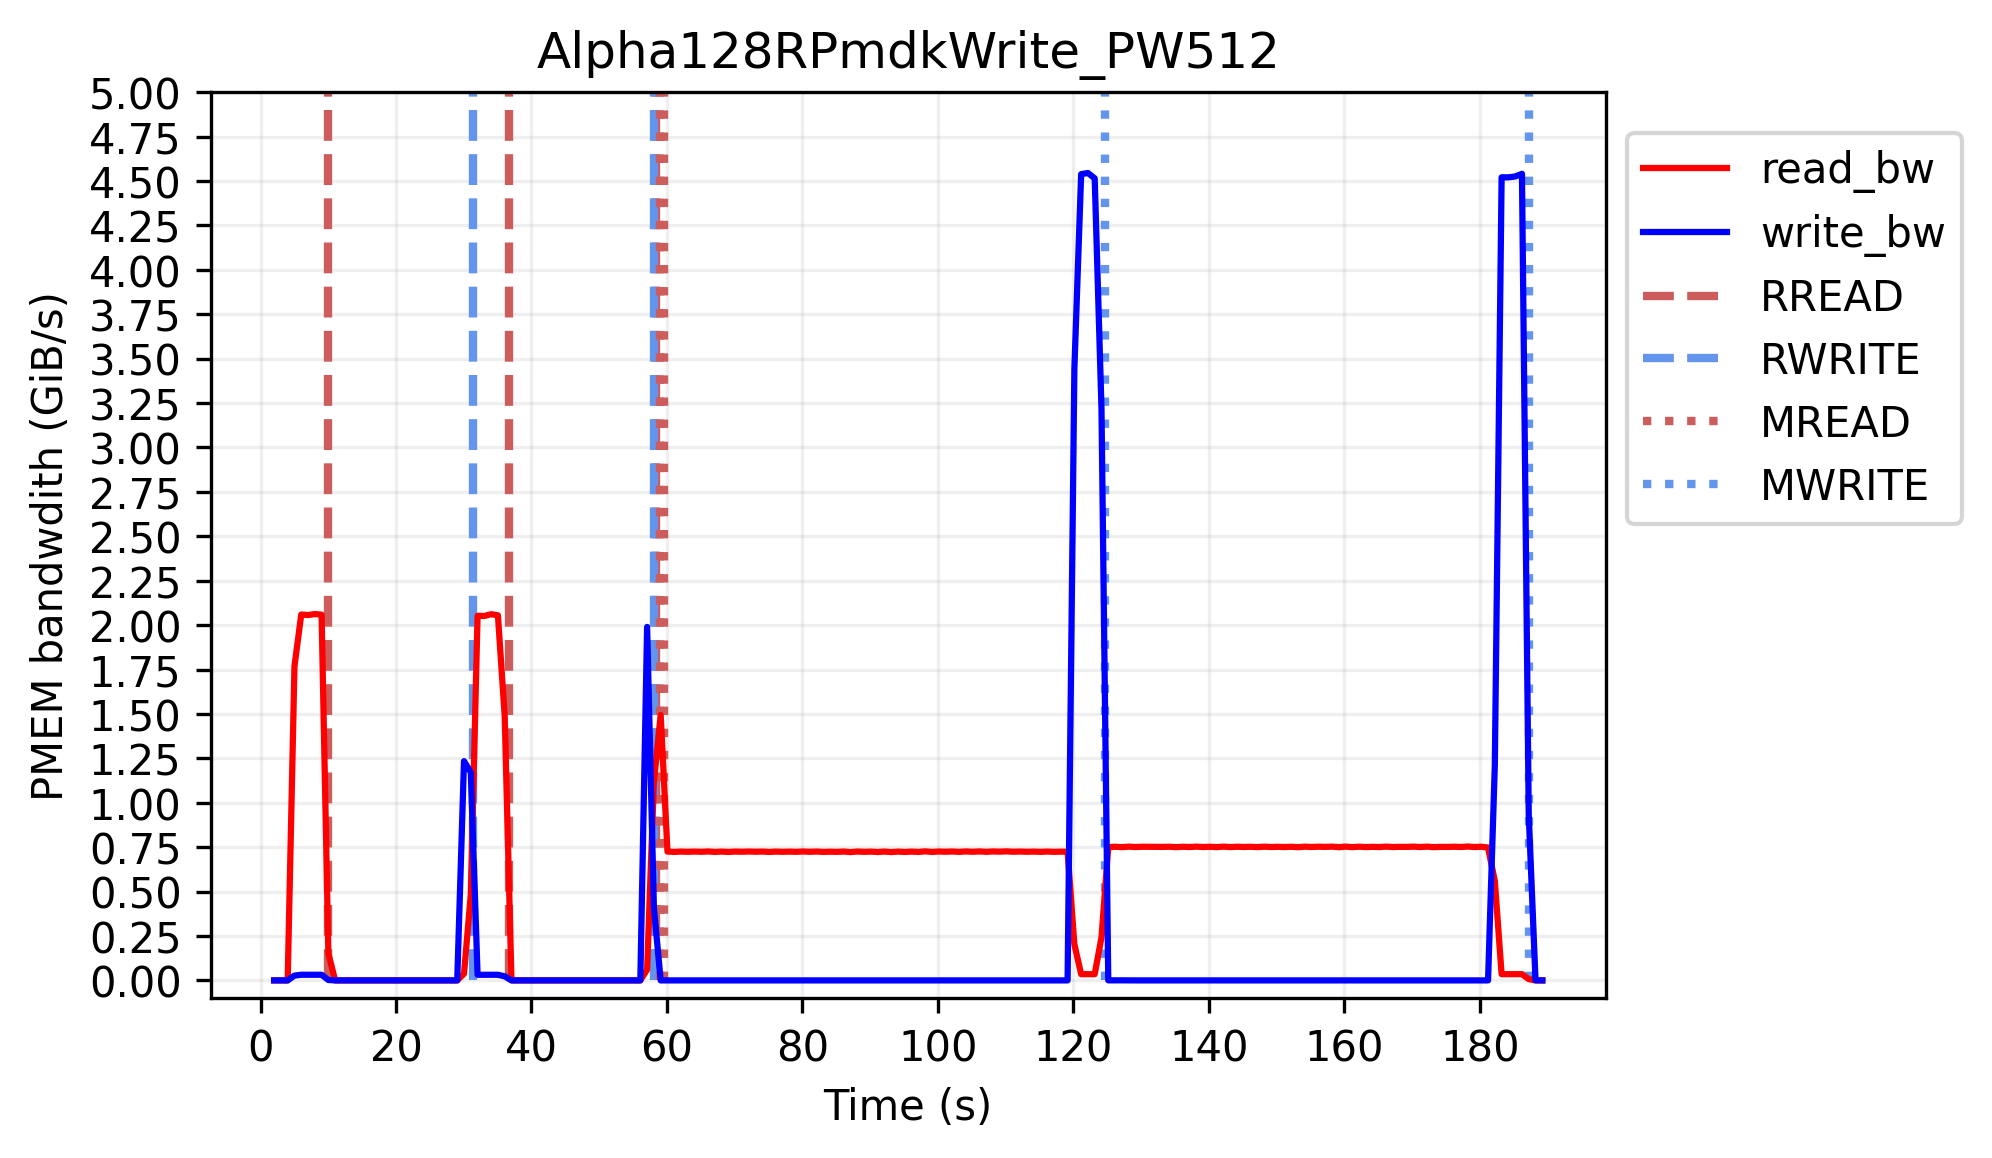

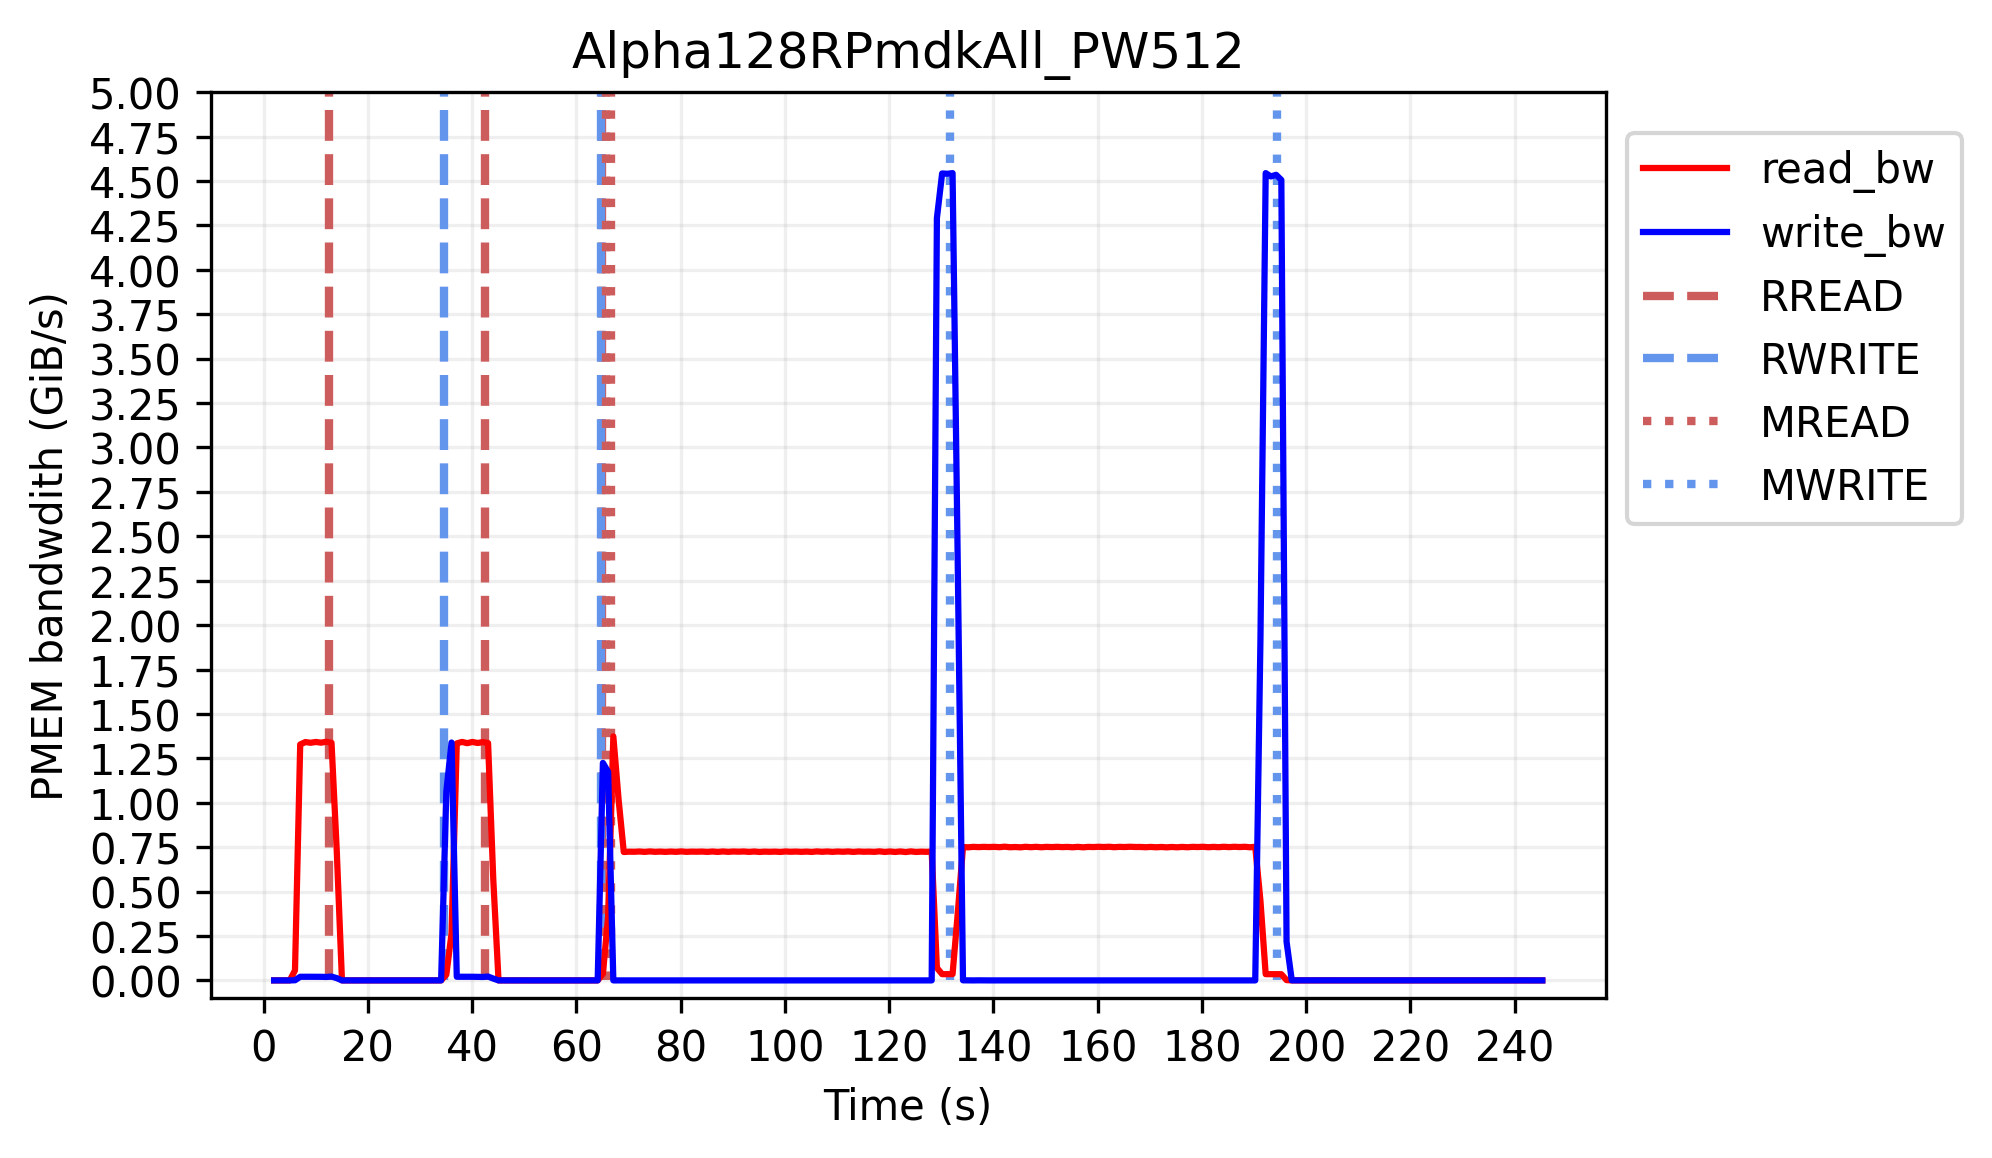

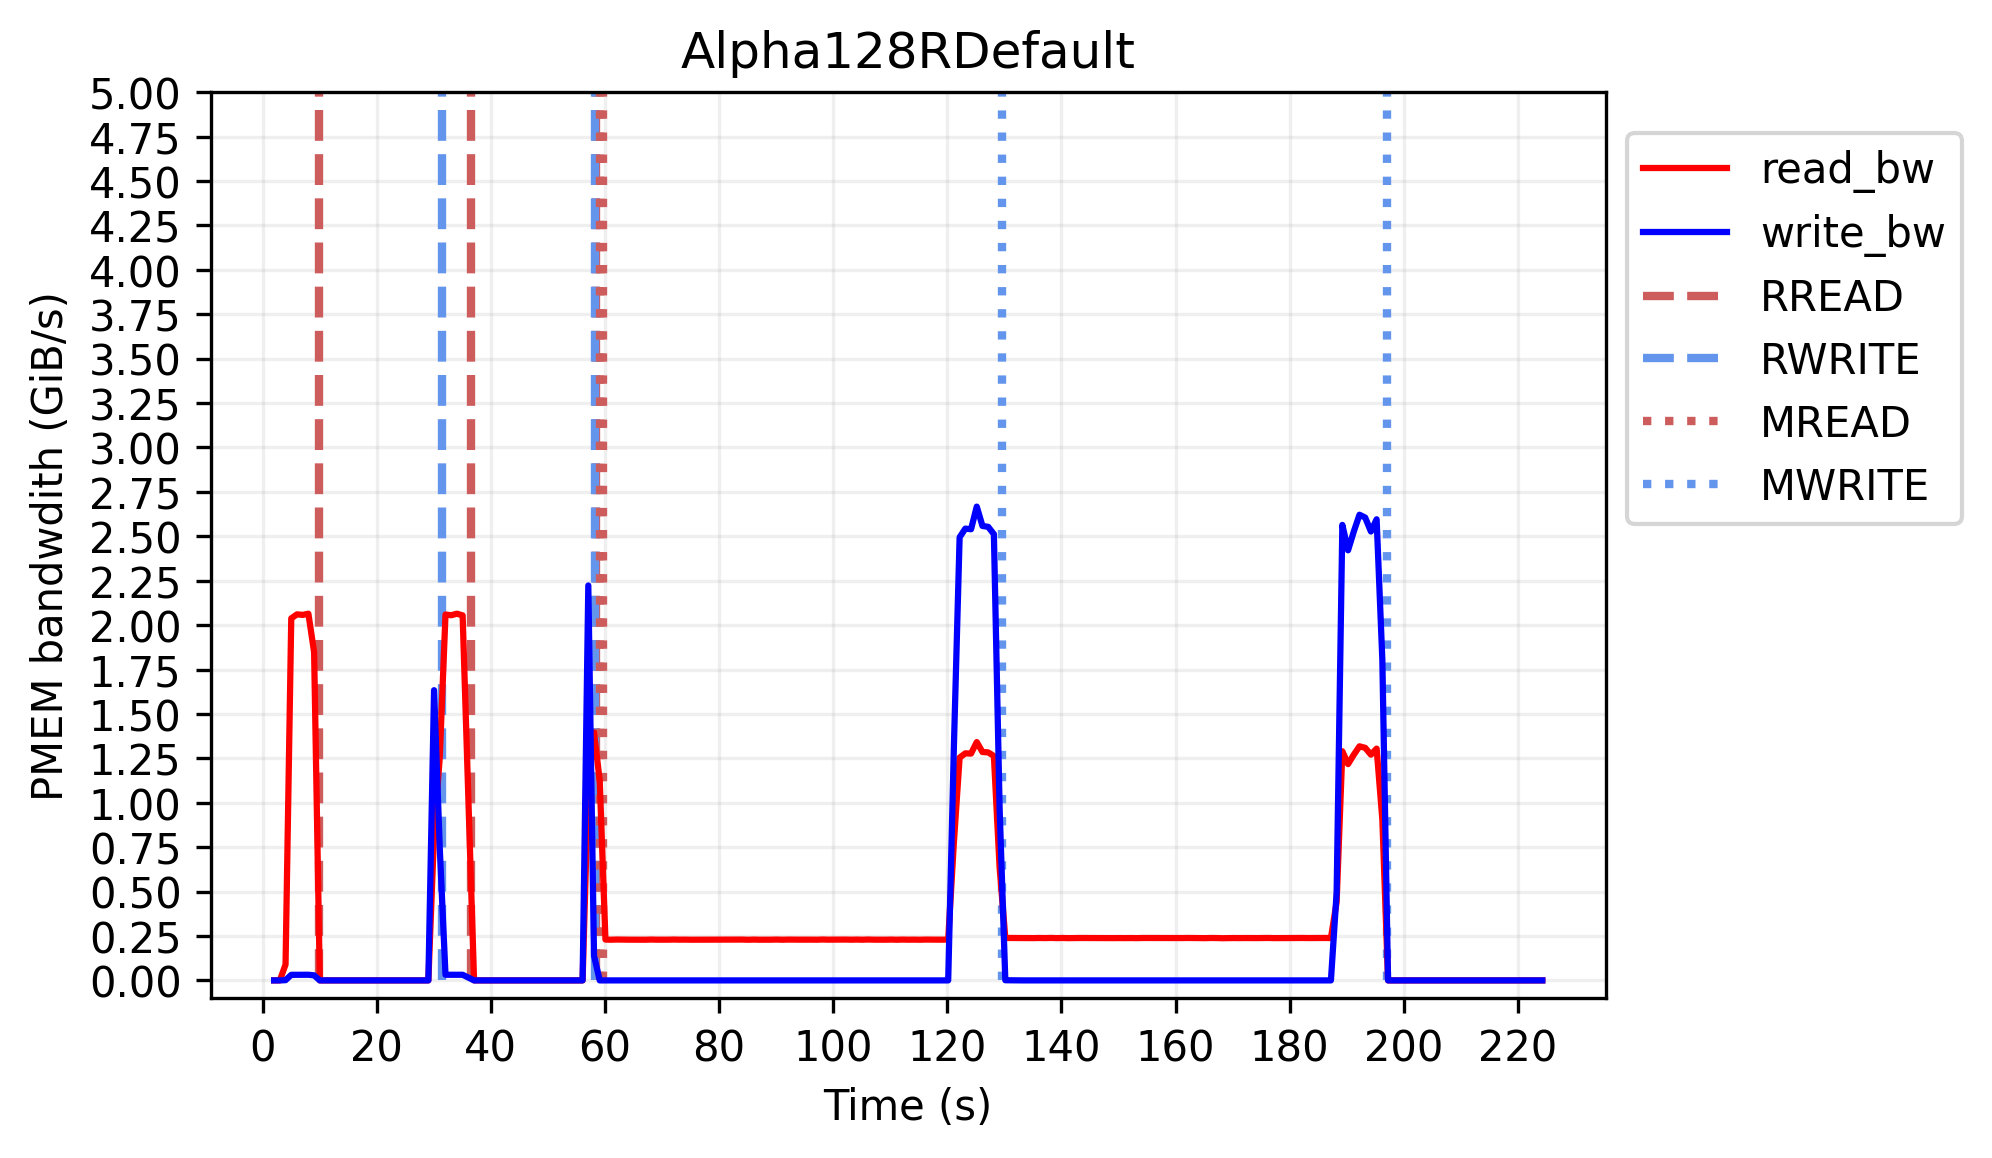

In [208]:
#pmem_wisc_bandwdith('3')
pmem_wisc_bandwdith('Alpha128RPmdkWrite_PW512')
pmem_wisc_bandwdith('Alpha128RPmdkAll_PW512')
pmem_wisc_bandwdith('Alpha128RDefault')

{'RUN read': [9.984302, 25.770135, 36.58702], 'SORT': [19.730328, 35.515375], 'RUN write': [20.559261, 36.345354], 'MERGE seq read': [36.740846000000005, 36.889931, 66.32396], 'MERGE write': [70.827923]}


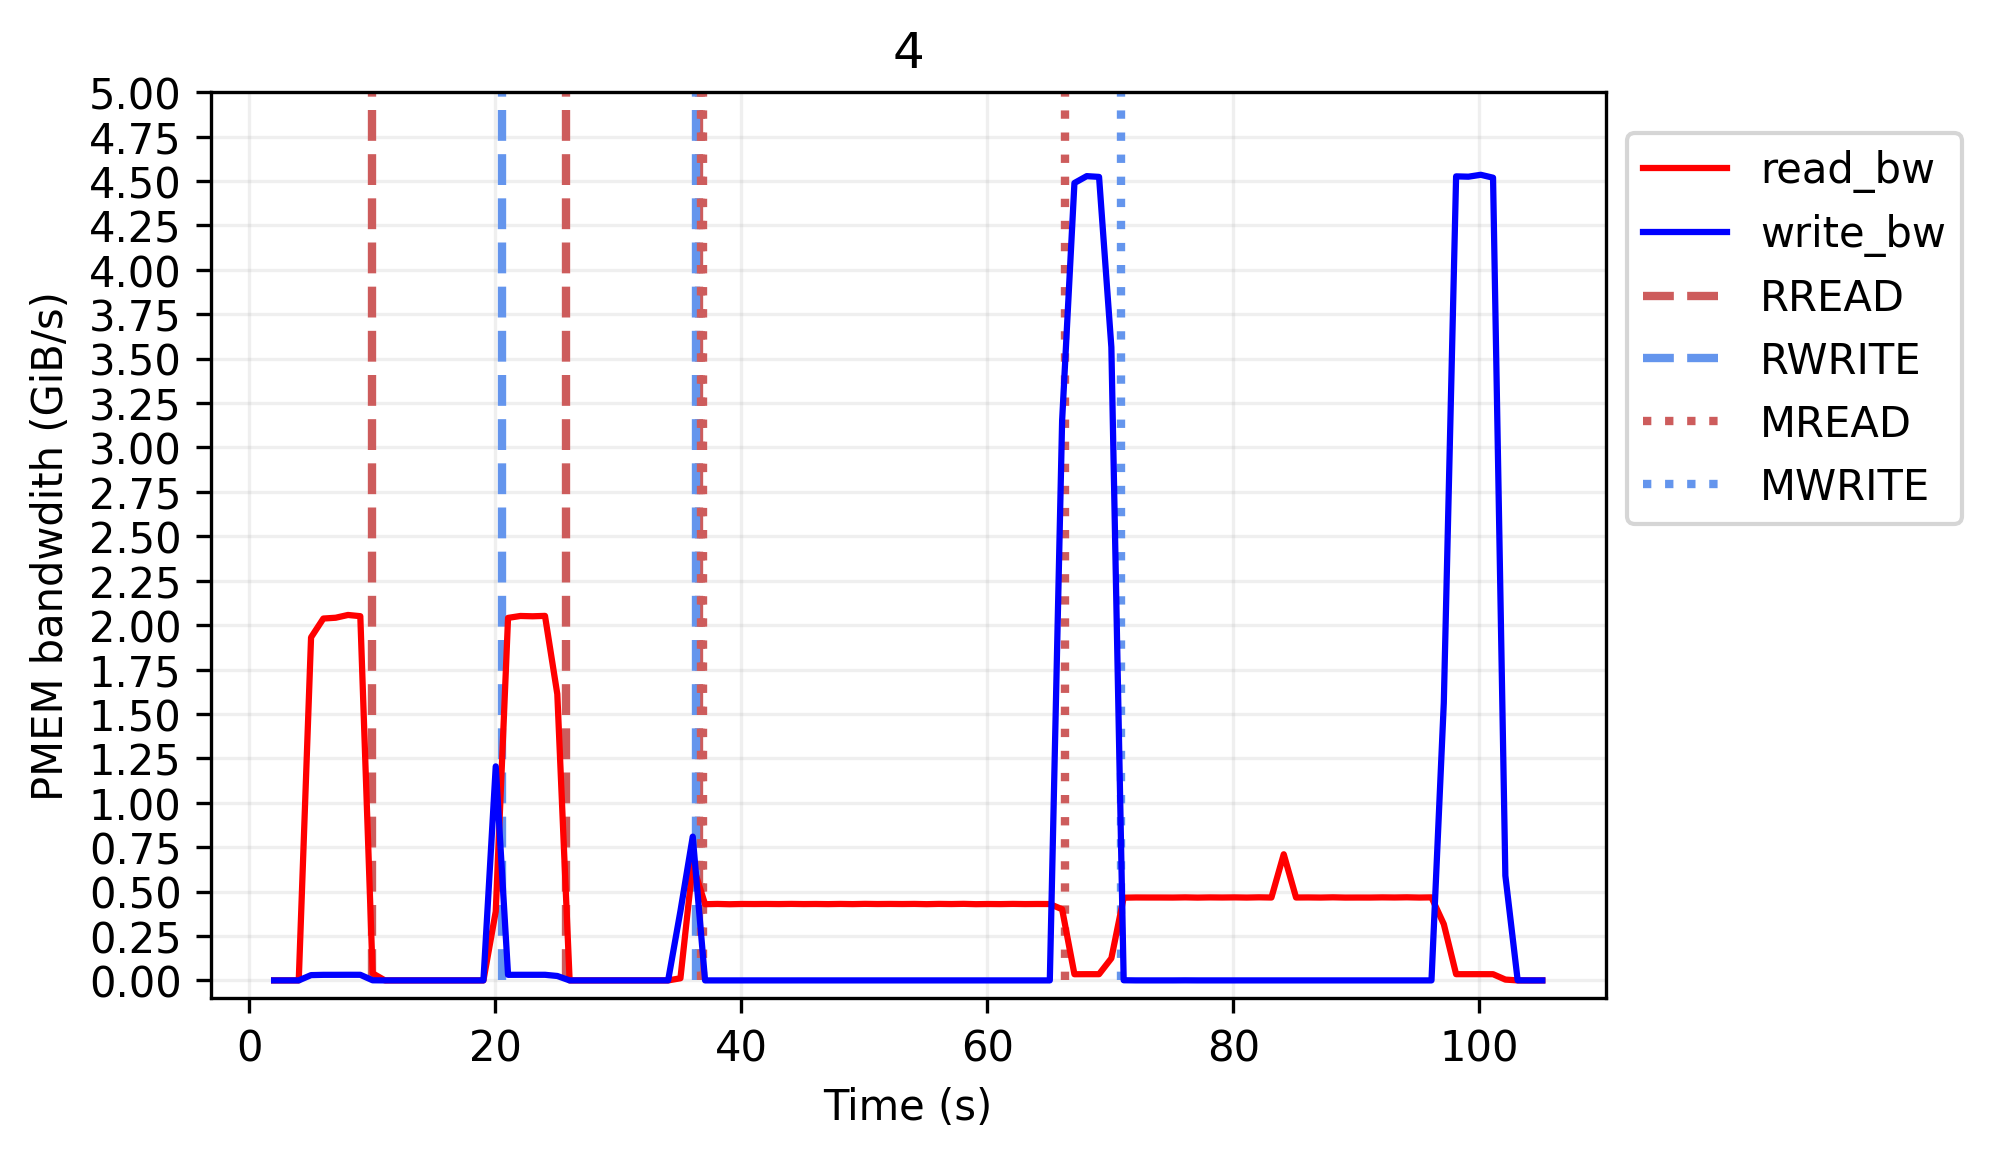

In [210]:
pmem_wisc_bandwdith('4')

## stacked graph - CXL

In [1287]:
## Stacked line graph to show run time.
def stacked_runtime(exps):
    labels = ['RUN read', 'RUN sort', 'RUN write', 'Total RUN', 'MERGE read', 'MERGE write', 'RECORD read', 'Total MERGE']
    cm = plt.get_cmap('RdYlBu')
    colors = cm(np.linspace(0, 1, len(labels)))
    full_data = {}
    for exp in exps:
        results = pd.read_csv("stats/"+f"{exp}" + "/results", delimiter=r":", header = None)
        begin = 0
        for idx, row in results.iterrows():
            if row[0].startswith("="):
                begin = idx+1
        results = results[begin:]
        data = {}
        for index, row in results.iterrows():
            data[f'{row[0].strip()}'] = row[1]
        if 'Total RUN' in data:
            if 'RUN read-write' in data:
                data['RUN read'] += data['RUN read-write']/2
                data['RUN write'] += data['RUN read-write']/2
            if 'Total MERGE' not in data and 'RECORD read' in data:
                data['Total RUN'] -= (data['RUN read'] + data['RUN sort'] + data['RUN write'] + data['RECORD read'])
            else:
                data['Total RUN'] -= (data['RUN read'] + data['RUN sort'] + data['RUN write'])
        else:
            data['RUN read'] = 0
            data['RUN write'] = 0
            data['RECORD read'] = 0
            data['Total RUN'] = 0
        if 'Total MERGE' in data:
            data['Total MERGE'] -= (data['MERGE read'] + data['MERGE write'])
        else:
            data['Total MERGE'] = 0
            data['MERGE read'] = 0
            data['MERGE write'] = 0
        if 'RECORD read' not in data:
            data['RECORD read'] = 0
        for row in data.keys():
            if row in full_data:
                full_data[row] += [float(data[row])]
            else:
                full_data[row] = []
                full_data[row] += [float(data[row])]
    # full_data['RECORD read'] = [0] + full_data['RECORD read']
    # del full_data['RUN read-write']
    full_data = pd.DataFrame.from_dict(full_data)
    full_data = full_data.rename(columns={'Total RUN':'RUN other', 'Total MERGE':'MERGE other'})
    full_data = full_data.iloc[:,[1, 0, 2, 4, 6, 7, 3, 5]]
    exps = [exp.split("/")[-1] for exp in exps]
    full_data['sort'] = ['SampleSort', 'External \n Merge Sort', 'MergePass', 'OnePass']
    full_data.set_index('sort')
    # plt.stackplot([exp.split("/")[-1] for exp in exps], [full_data[x] for x in labels], labels=labels, colors=colors)
    ax = full_data.plot(x='sort', kind='bar', stacked=True, cmap=plt.cm.RdYlBu,                       
                       linewidth=0.4,
                      edgecolor='black',
                      alpha = 0.93,
                      rot = 0)
    # plt.bar(exps, np.array(full_data[labels[2]]))
    # plt.grid(axis='x')
    ax.set_axisbelow(True)
    plt.grid(alpha=0.22, axis='y')
    plt.ylabel("Time (s)")
    plt.xlabel("")
    plt.yticks(np.arange(0, 140, step=20))
    plt.ylim(0, 140)
    plt.legend(loc='upper right',  bbox_to_anchor=(1.02,0.88), prop={'size': 9}, ncol=2, frameon= False)
    plt.legend('', frameon=False)
    # plt.show()
    plt.savefig('cxl-ba-RR-ARW.pdf', bbox_inches="tight")
    # plt.savefig('cxl-ba-RR.pdf', bbox_inches="tight")
    # plt.savefig('cxl-ba.pdf', bbox_inches="tight")
    

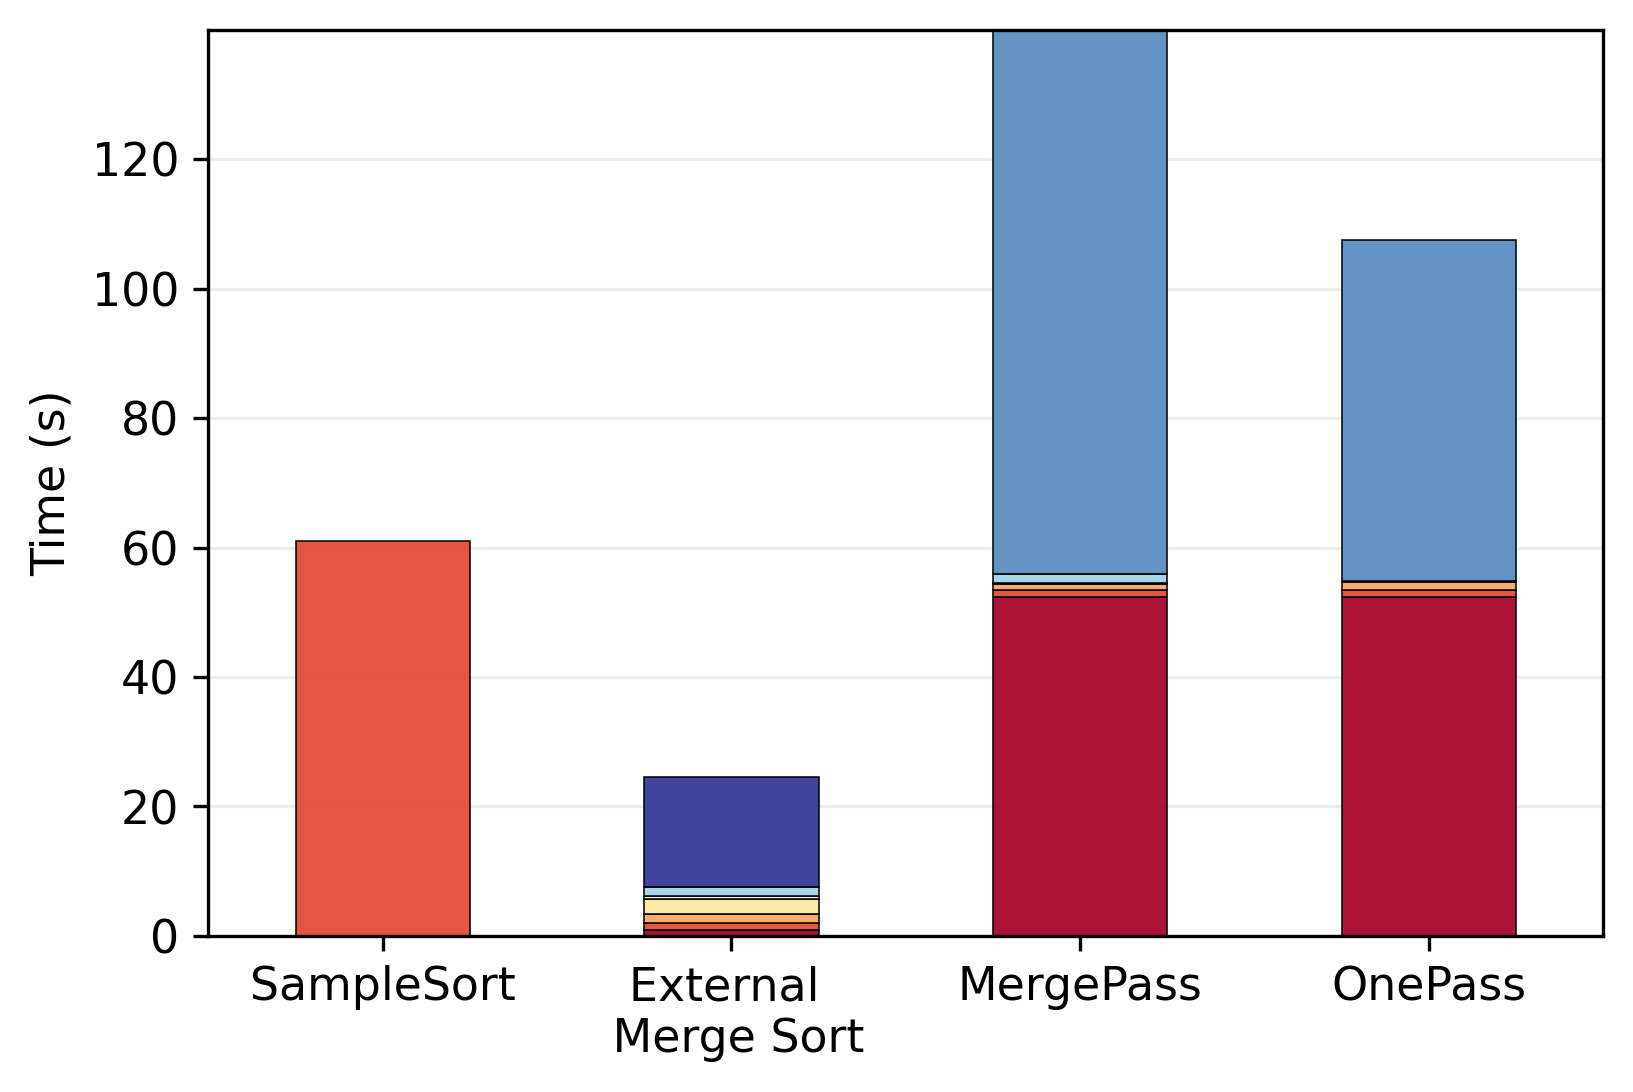

In [1290]:
plt.rcParams.update({'font.size': 11})
# stacked_runtime(['paper/cxlBAS/ba_irrp_arwc/10/SampleSort','paper/cxlBAS/ba_irrp_arwc/10/CEMS','paper/cxlBAS/ba_irrp_arwc/10/MergePass', 'paper/cxlBAS/ba_irrp_arwc/10/OnePass'])
# stacked_runtime(['paper/cxlBAS/ba_irrp/10/SampleSort','paper/cxlBAS/ba_irrp/10/CEMS','paper/cxlBAS/ba_irrp/10/MergePass', 'paper/cxlBAS/ba_irrp/10/OnePass'])
stacked_runtime(['paper/cxlBAS/ba/10/SampleSort','paper/cxlBAS/ba/10/CEMS','paper/cxlBAS/ba/10/MergePass', 'paper/cxlBAS/ba/10/OnePass'])

## pmsort

In [1185]:
## Stacked line graph to show run time.
def stacked_runtime(exps):
    labels = ['RUN read', 'RUN sort', 'RUN write', 'Total RUN', 'MERGE read', 'MERGE write', 'RECORD read', 'Total MERGE']
    cm = plt.get_cmap('RdYlBu')
    colors = cm(np.linspace(0, 1, len(labels)))
    full_data = {}
    for exp in exps:
        results = pd.read_csv("stats/paper/"+f"{exp}" + "/results", delimiter=r":", header = None)
        begin = 0
        for idx, row in results.iterrows():
            if row[0].startswith("="):
                begin = idx+1
        results = results[begin:]
        data = {}
        for index, row in results.iterrows():
            data[f'{row[0].strip()}'] = row[1]
        if 'Total RUN' in data:
            if 'RUN read-write' in data:
                data['RUN read'] += data['RUN read-write']/2
                data['RUN write'] += data['RUN read-write']/2
            if 'Total MERGE' not in data and 'RECORD read' in data:
                data['Total RUN'] -= (data['RUN read'] + data['RUN sort'] + data['RUN write'] + data['RECORD read'])
            else:
                data['Total RUN'] -= (data['RUN read'] + data['RUN sort'] + data['RUN write'])
        else:
            data['RUN read'] = 0
            data['RUN write'] = 0
            data['RECORD read'] = 0
            data['Total RUN'] = 0
        if 'Total MERGE' in data:
            data['Total MERGE'] -= (data['MERGE read'] + data['MERGE write'])
        else:
            data['Total MERGE'] = 0
            data['MERGE read'] = 0
            data['MERGE write'] = 0
        if 'RECORD read' not in data:
            data['RECORD read'] = 0
        for row in data.keys():
            if row in full_data:
                full_data[row] += [float(data[row])]
            else:
                full_data[row] = []
                full_data[row] += [float(data[row])]
    # full_data['RECORD read'] = [0] + full_data['RECORD read']
    del full_data['RUN read-write']
    full_data = pd.DataFrame.from_dict(full_data)
    full_data = full_data.rename(columns={'Total RUN':'RUN other', 'Total MERGE':'MERGE other'})
    full_data = full_data.iloc[:,[1, 0, 2, 4, 6, 7, 3, 5]]
    exps = [exp.split("/")[-1] for exp in exps]
    full_data['sort'] = ['PMSort \n OnePass \n single', 
                         'WiscSort \n OnePass \n single',
                         'PMSort \n OnePass \n multi', 
                         'WiscSort \n OnePass \n multi',
                         'PMSort \n MergePass \n single', 
                         'WiscSort \n MergePass \n single',
                         'PMSort \n MergePass \n multi', 
                         'WiscSort \n MergePass \n multi']
    full_data.set_index('sort')
    # plt.stackplot([exp.split("/")[-1] for exp in exps], [full_data[x] for x in labels], labels=labels, colors=colors)
    full_data.plot(x='sort', kind='bar', stacked=True, cmap=plt.cm.RdYlBu,                       
                       linewidth=0.4,
                      edgecolor='black',
                      alpha = 0.93,
                      rot = 90)
    # plt.bar(exps, np.array(full_data[labels[2]]))
    # plt.grid(axis='x')
    plt.grid(alpha=0.22)
    plt.ylabel("Time (s)")
    plt.xlabel("")
    plt.yticks(np.arange(0, 250, step=20))
    plt.ylim(0, 250)
    plt.legend(loc='upper right',  bbox_to_anchor=(0.98,1), prop={'size': 9})
    plt.legend('', frameon=False)
    plt.show()
    

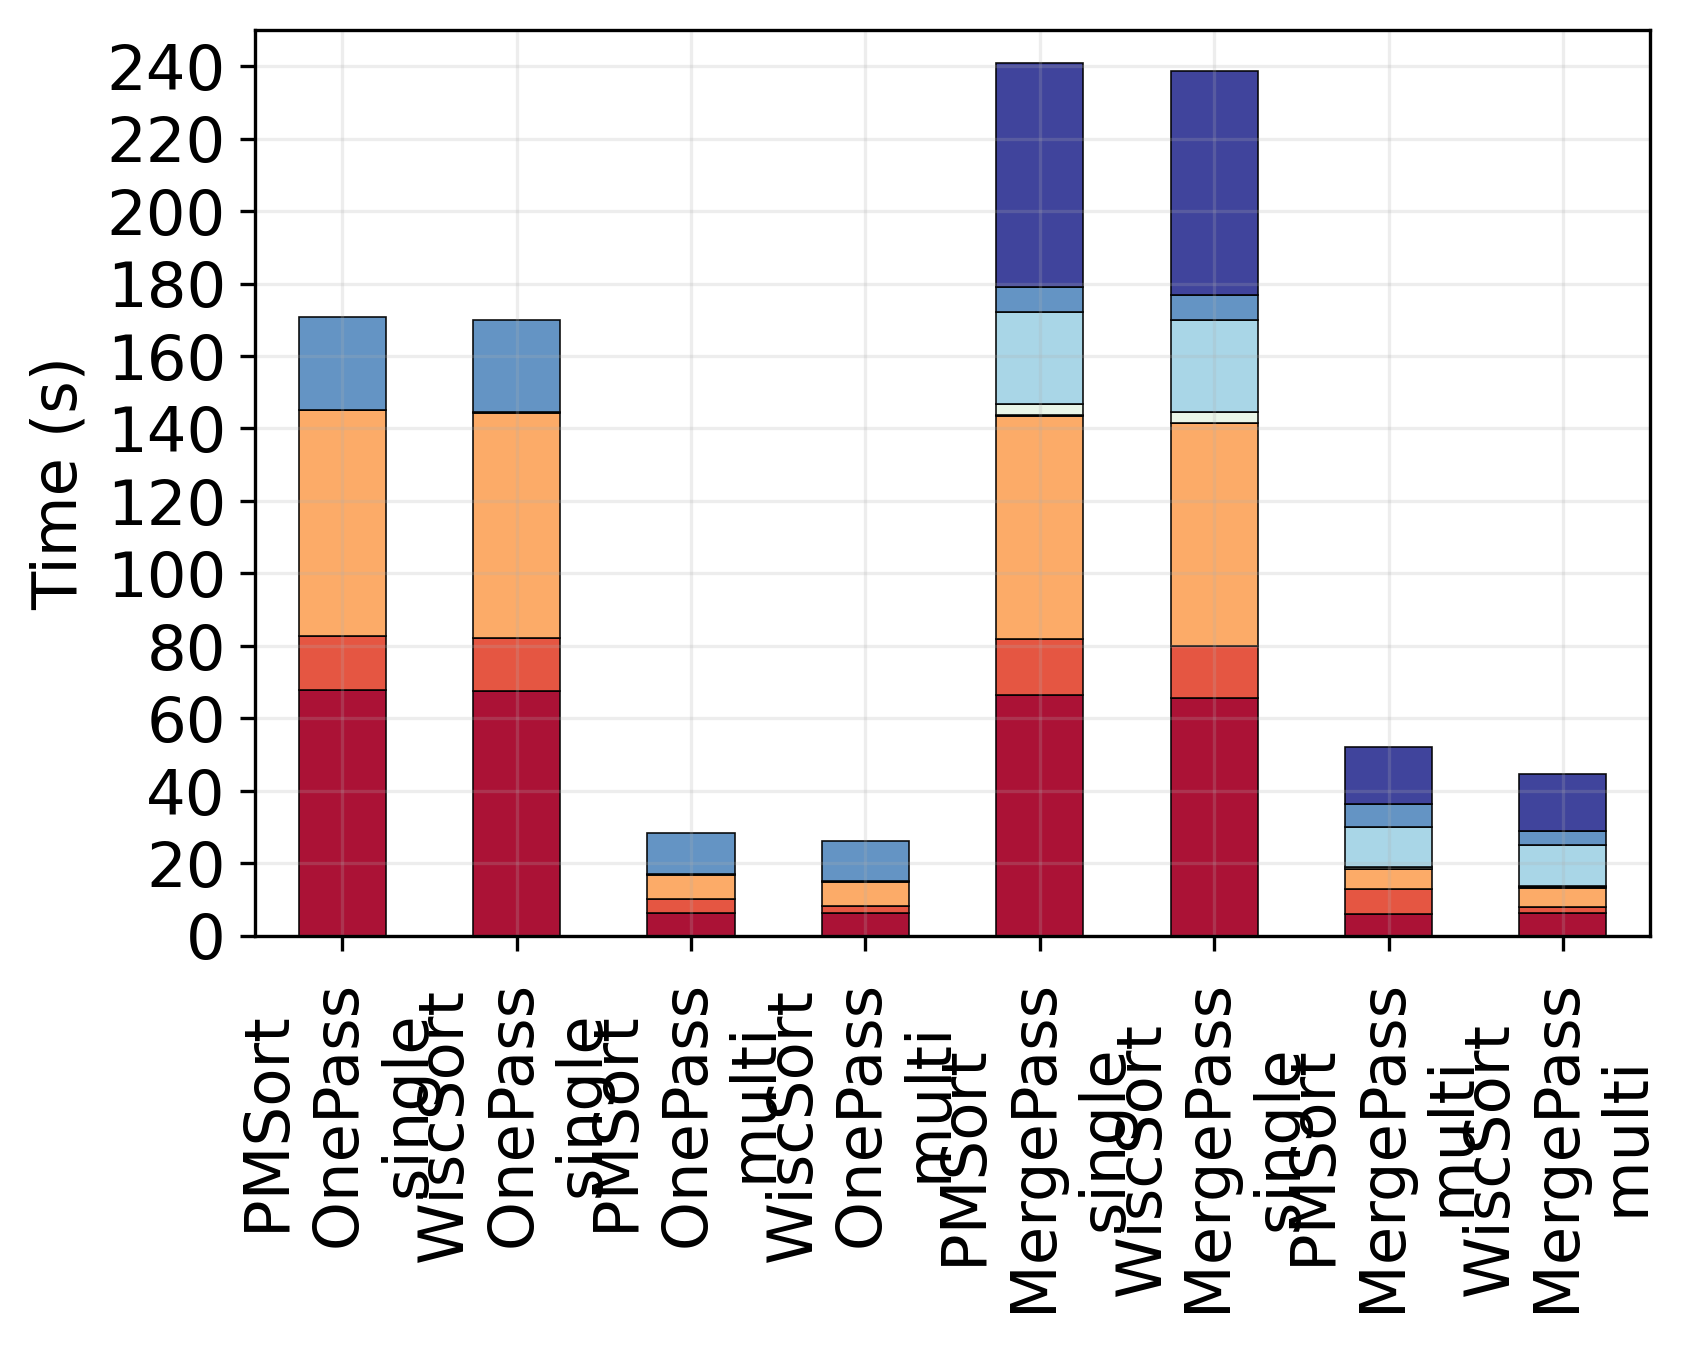

In [1186]:
stacked_runtime([
'pmsort/40/pm_onepass_single',
'pmsort/40/wisc_onepass_single',
'pmsort/40/pm_onepass_multi',
'pmsort/40/wisc_onepass_multi',
'pmsort/40/pm_merge_single',
'pmsort/40/wisc_merge_single',
'pmsort/40/pm_merge_multi',
'pmsort/40/wisc_merge_multi'])

In [956]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

df = pd.DataFrame()
def plot_clustered_stacked(dfall, labels=None, title="multiple stackedl bar plot",  H="//", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      linewidth=0.4,
                      edgecolor='black',
                      alpha = 0.93,
                      **kwargs)  # make bar plots
        #for container in axe.containers:
            #axe.bar_label(container)
    
    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for ind,rect in enumerate(pa.patches): # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch("//" * int(i*3 / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))
        
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)
    #axe.set_xlim(xmax=len(dfall)-1)
    axe.grid(alpha=0.22)
    #axe.set_yscale('log')
    #axe.set_yticks(np.arange(0,10^6, 10^2))
    axe.set_yticks(np.arange(0, 300, 10))
    #axe.set_xlabel("Dataset size (GB)")
    # axe.set_xlabel("Dataset size (GB)")
    axe.set_ylabel("Time (s)")
    # For num of ops
    #axe.set_yticks(np.arange(0, 2.5e+12, 0.25e+12))
    # For data in TB
    #axe.set_yticks(np.arange(0,250, 25))

    # Add invisible data to add another legend
    n=[]        
    # l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.4])
    # l1 = axe.legend(h[:n_col], l[:n_col], loc='center', bbox_to_anchor=(0.885,0.69),  prop={'size': 6})
    l1 = axe.legend(h[:n_col], l[:n_col], loc='center', bbox_to_anchor=(1.1,0.69),  prop={'size': 6})
    axe.add_artist(l1)
    
    n.append(axe.bar(0, 0, color="gray", hatch=H * 0)) #PMSort
    n.append(axe.bar(0, 0, color="gray", hatch=H * 3)) #WiscSort
    # n.append(axe.bar(0,0, color="gray", hatch="/" *3)) #MergePass
    
    labels = ['PMSort', 'WiscSort']
    if labels is not None:
        # l2 = plt.legend(n, labels, loc=[1.01, 0.1])
        # l2 = plt.legend(n, labels, loc='upper right',  bbox_to_anchor=(0.96,0.98), prop={'size': 6})
        l2 = plt.legend(n, labels, loc='upper right',  bbox_to_anchor=(1.2,0.98), prop={'size': 6})
    return axe

def stacked_bar_runtime(folder,iters, exps):
    send = []
    labels = ['RUN read', 'RUN sort', 'RUN write', 'RUN other', 'MERGE read', 'MERGE write', 'RECORD read', 'MERGE other']
    for ix,exp in enumerate(exps):
        df = pd.DataFrame([], columns = labels)
        for dnum in iters:
            results = pd.read_csv("stats/"+f"{folder}/{dnum}/"+f"{exp}" + "/results", delimiter=r":", header = None)
            begin = 0
            for idx, row in results.iterrows():
                if row[0].startswith("="):
                    begin = idx+1
            results = results[begin:]
            results.index = range(0,len(results))
            for idx, row in results.iterrows():
                results.at[idx,0] = row[0].strip()
            results = results.T
            results.columns = results.loc[0, :].values.tolist()
            ix = exp
            results = results.drop(results.index[0])
            # if exp == exps[(len(exps)-1)]:
            #     results.index = [dnum]
            #     ix = dnum
            results.index = [ix]
            if 'Total' in results.columns:
                results = results.drop(columns = ['Total'])
            if 'Total RUN' in results.columns:
                results.at[ix, 'Total RUN'] -= (results.at[ix,'RUN read'] + results.at[ix,'RUN sort'] + results.at[ix,'RUN write'])
            ## adding random read
            if 'RECORD read' in results.columns and 'Total MERGE' not in results.columns:
                results.at[ix, 'Total RUN'] -= results.at[ix, 'RECORD read']
            if 'RECORD read' in results.columns and 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= results.at[ix, 'RECORD read']
            if 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= (results.at[ix,'MERGE read'] + results.at[ix,'MERGE write'])
            else:
                results.at[ix,'Total MERGE'] = 0
                results.at[ix,'MERGE read'] = 0
                results.at[ix,'MERGE write'] = 0
            split = dnum.split("_")
            split = "{0}\n{1}".format(split[0], split[1])
            results.index = [split]

            # Renaming 'Total' to 'other'
            results = results.rename(columns={'Total RUN':'RUN other', 'Total MERGE': 'MERGE other'})
            
            df = pd.concat([df, results])
            #print(df)
        send.append(df)
        print(exp)
        print(df)
    plot_clustered_stacked(send, exps, title="", cmap=plt.cm.RdYlBu)

PMSort
                  RUN read RUN sort RUN write RUN other MERGE read  \
OnePass\nSingle    14.9931  67.8258    25.593  0.171581          0   
MergePass\nSingle  15.4473   66.369   6.87736  0.203053    2.85521   

                  MERGE write RECORD read MERGE other  
OnePass\nSingle             0      62.194           0  
MergePass\nSingle     25.5806     61.7443    0.147653  
WiscSort
                  RUN read RUN sort RUN write RUN other MERGE read  \
OnePass\nSingle    14.4583  67.6856    25.576  0.168503          0   
MergePass\nSingle  14.2901  65.5956   6.89651  0.174388    2.84082   

                  MERGE write RECORD read MERGE other  
OnePass\nSingle             0     62.1702           0  
MergePass\nSingle     25.5422     61.5419    0.205099  


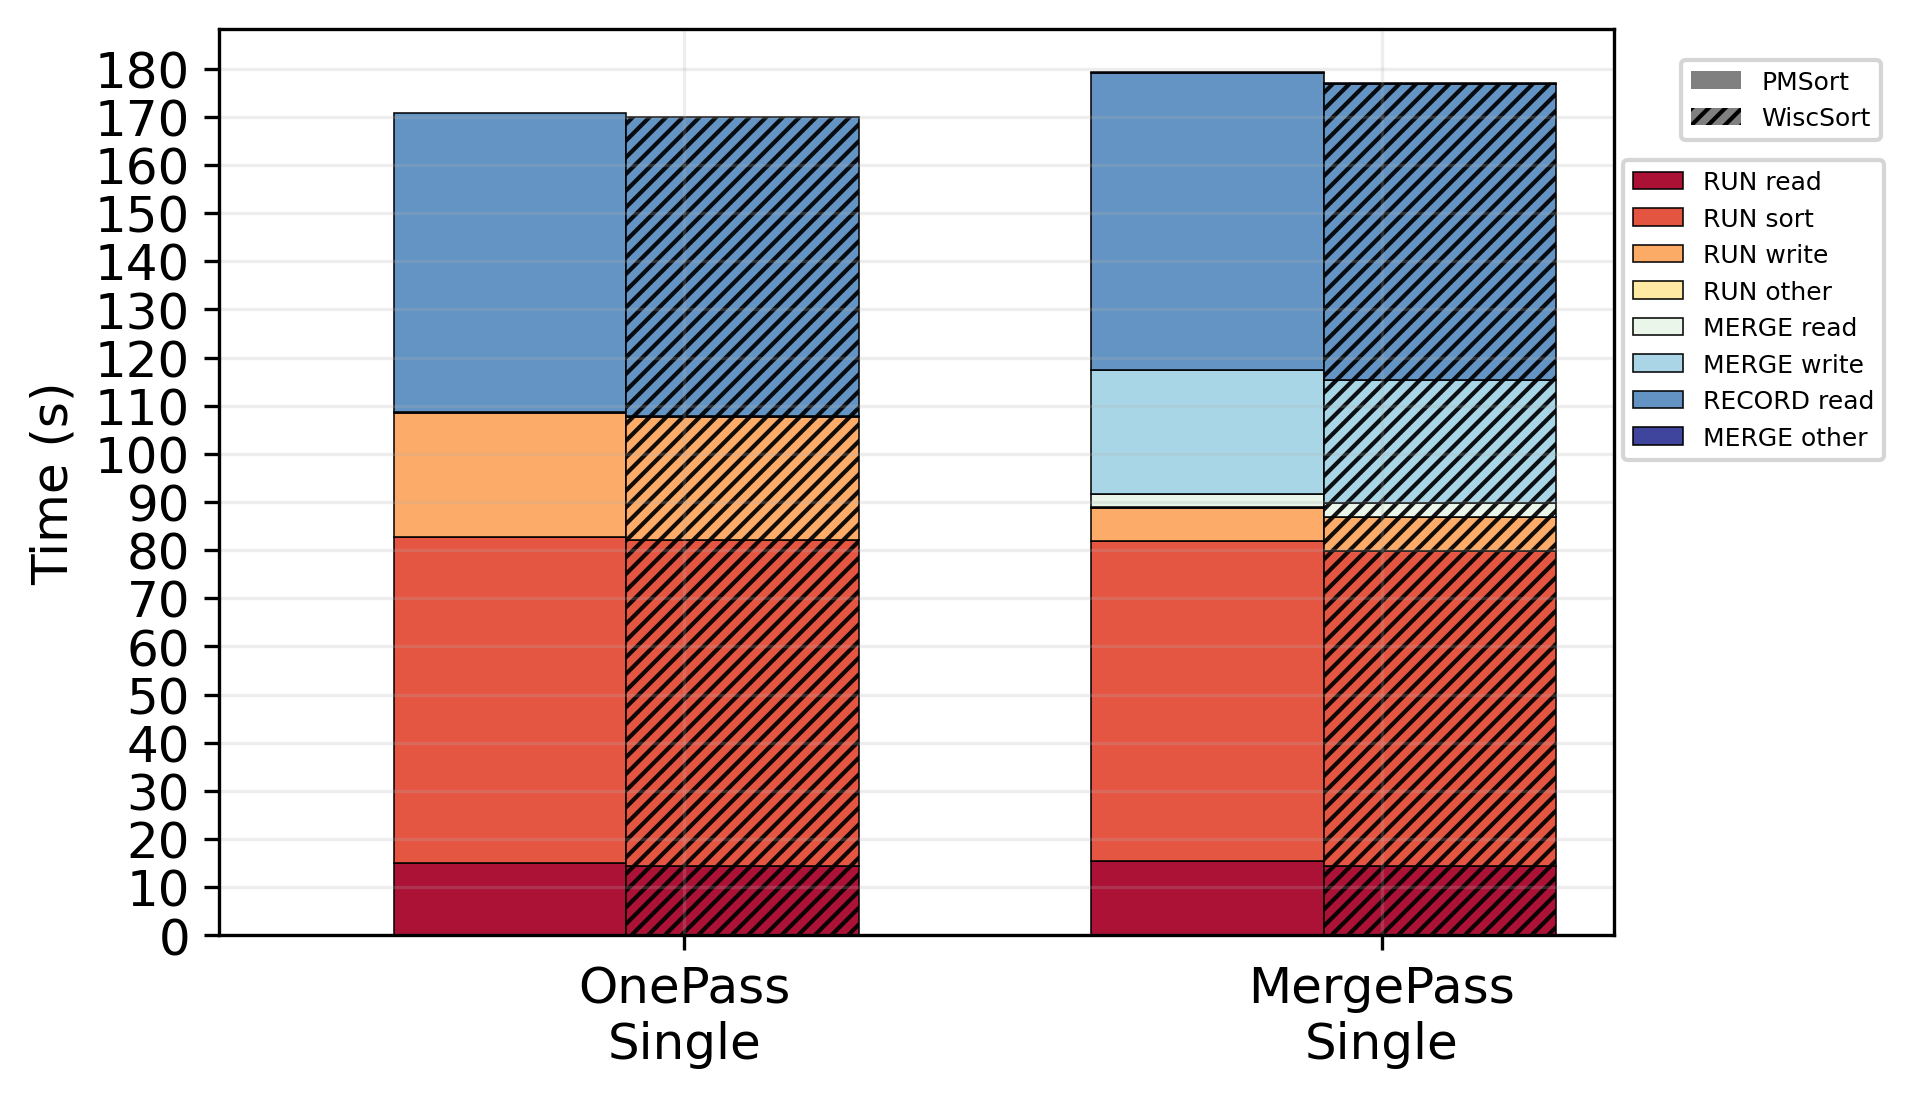

In [957]:
# stacked_bar_runtime('1_second_granularity/5gb_ReadB-5gb_WriteB',['20', '40', '60', '80', '100'],['CEMS', 'WiscSort'])
# stacked_bar_runtime('paper/pmsort/40/stacked_grouped',['OnePass_Single', 'OnePass_Multi', 'MergePass_Single', 'MergePass_Multi'],['PMSort', 'WiscSort'])
stacked_bar_runtime('paper/pmsort/40/stacked_grouped',['OnePass_Single', 'MergePass_Single'],['PMSort', 'WiscSort'])

## Graysort

In [31]:
## This generates with gaps between EMS WSO WSM
plt.rcParams.update({'font.size': 12})

df = pd.DataFrame()
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="x", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    f = plt.figure(figsize=(6,4))
    axe = f.add_subplot(111)
    # axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      linewidth=0.4,
                      edgecolor='black',
                      alpha = 0.93,
                      **kwargs)  # make bar plots
        #for container in axe.containers:
            #axe.bar_label(container)
    
    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for ind,rect in enumerate(pa.patches): # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                if ind > 2:
                    # rect.set_hatch("//" * int(i*1 / n_col)) #edited part     
                    rect.set_hatch("" * int(i*1 / n_col)) #edited part     
                else:
                    # rect.set_hatch("x" * int(i*3 / n_col)) #edited part     
                    rect.set_hatch("" * int(i*3 / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))
        
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)
    #axe.set_xlim(xmax=len(dfall)-1)
    axe.set_axisbelow(True)
    axe.grid(alpha=0.22, axis='y')
    #axe.set_yscale('log')
    #axe.set_yticks(np.arange(0,10^6, 10^2))
    axe.set_yticks(np.arange(0, 500, 30))
    #axe.set_xlabel("Dataset size (GB)")
    axe.set_xlabel("Dataset size (GB)")
    axe.set_ylabel("Time (s)")
    # For num of ops
    #axe.set_yticks(np.arange(0, 2.5e+12, 0.25e+12))
    # For data in TB
    #axe.set_yticks(np.arange(0,250, 25))
    
    # axe.margins(x=0, y=0.05)

    # Add invisible data to add another legend
    n=[]        
    # l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.4])
    l1 = axe.legend(h[:n_col], l[:n_col], loc='upper left', prop={'size': 10}, frameon = False, ncol=2)
    axe.add_artist(l1)
    
    n.append(axe.bar(0, 0, color="gray", hatch=H * 0)) #CEMS
    n.append(axe.bar(0, 0, color="gray", hatch=H * 3)) #OnePass
    n.append(axe.bar(0,0, color="gray", hatch="//" *3)) #MergePass
    
    labels = ['Ext Merge Sort', 'WiscSort OnePass', 'WiscSort MergePass']
    # if labels is not None:
    #     l2 = plt.legend(n, labels, loc='upper center',  bbox_to_anchor=(0.55,1), prop={'size': 10}, frameon = False)

def stacked_bar_runtime(folder,iters, exps):
    send = []
    labels = ['RUN read', 'RUN sort', 'RUN write', 'RUN other', 'MERGE read', 'MERGE write', 'RECORD read', 'MERGE other']
    for ix,exp in enumerate(exps):
        df = pd.DataFrame([], columns = labels)
        for dnum in iters:
            results = pd.read_csv("stats/"+f"{folder}/{dnum}/"+f"{exp}" + "/results", delimiter=r":", header = None)
            begin = 0
            for idx, row in results.iterrows():
                if row[0].startswith("="):
                    begin = idx+1
            results = results[begin:]
            results.index = range(0,len(results))
            for idx, row in results.iterrows():
                results.at[idx,0] = row[0].strip()
            results = results.T
            results.columns = results.loc[0, :].values.tolist()
            ix = exp
            results = results.drop(results.index[0])
            # if exp == exps[(len(exps)-1)]:
            #     results.index = [dnum]
            #     ix = dnum
            results.index = [ix]
            
            if 'Total' in results.columns:
                results = results.drop(columns = ['Total'])
            if 'Total RUN' in results.columns:
                results.at[ix, 'Total RUN'] -= (results.at[ix,'RUN read'] + results.at[ix,'RUN sort'] + results.at[ix,'RUN write'])
            ## adding random read
            if 'RECORD read' in results.columns and 'Total MERGE' not in results.columns:
                results.at[ix, 'Total RUN'] -= results.at[ix, 'RECORD read']
            if 'RECORD read' in results.columns and 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= results.at[ix, 'RECORD read']
            if 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= (results.at[ix,'MERGE read'] + results.at[ix,'MERGE write'])
            else:
                results.at[ix,'Total MERGE'] = 0
                results.at[ix,'MERGE read'] = 0
                results.at[ix,'MERGE write'] = 0
            results.index = [dnum]

            # Renaming 'Total' to 'other'
            results = results.rename(columns={'Total RUN':'RUN other', 'Total MERGE': 'MERGE other'})
            
            if (dnum == '160' or dnum == '200') and exp == 'WiscSort':
                for col in results.columns:
                    results[col].values[:] = 0              
            
            if (dnum == '40' or dnum == '80' or dnum == '120') and exp == 'WiscSort_merge':
                for col in results.columns:
                    results[col].values[:] = 0
                                              
            df = pd.concat([df, results])
            # print(df)
        send.append(df)
        # print(exp)
        # print(df)
    plot_clustered_stacked(send, exps, title="", cmap=plt.cm.RdYlBu)

In [50]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 12})

df = pd.DataFrame()
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="x", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      linewidth=0.4,
                      edgecolor='black',
                      alpha = 0.93,
                      **kwargs)  # make bar plots
        #for container in axe.containers:
            #axe.bar_label(container)
    
    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for ind,rect in enumerate(pa.patches): # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                if ind > 2:
                    rect.set_hatch("/" * int(i*2 / n_col)) #edited part
                else:
                    rect.set_hatch("x" * int(i*3 / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))
        
    plt.rcParams['hatch.linewidth'] = 0.60
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)
    #axe.set_xlim(xmax=len(dfall)-1)
    axe.grid(alpha=0.22, axis='y')
    #axe.set_yscale('log')
    #axe.set_yticks(np.arange(0,10^6, 10^2))
    axe.set_yticks(np.arange(0, 500, 30))
    #axe.set_xlabel("Dataset size (GB)")
    axe.set_xlabel("Dataset size (GB)")
    axe.set_ylabel("Time (s)")
    # For num of ops
    #axe.set_yticks(np.arange(0, 2.5e+12, 0.25e+12))
    # For data in TB
    #axe.set_yticks(np.arange(0,250, 25))

    # Add invisible data to add another legend
    n=[]        
    # l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.4])
    l1 = axe.legend(h[:n_col], l[:n_col], loc='upper left', prop={'size': 10}, frameon = False)
    axe.add_artist(l1)
    
    n.append(axe.bar(0, 0, color="gray", hatch=H * 0, alpha=.99)) #CEMS
    n.append(axe.bar(0, 0, color="gray", hatch=H * 3, alpha=.99))  #OnePass
    n.append(axe.bar(0,0, color="gray", hatch="/" *3, alpha=.99))  #MergePass
    
    labels = ['External Merge Sort', 'WiscSort OnePass', 'WiscSort MergePass']
    if labels is not None:
        # l2 = plt.legend(n, labels, loc=[1.01, 0.1])
        l2 = plt.legend(n, labels, loc='upper center',  bbox_to_anchor=(0.49,1), prop={'size': 10}, frameon = False)
    plt.savefig('graphs/graysort.pdf', bbox_inches="tight")
    return axe

def stacked_bar_runtime(folder,iters, exps):
    send = []
    labels = ['RUN read', 'RUN sort', 'RUN write', 'RUN other', 'MERGE read', 'MERGE write', 'RECORD read', 'MERGE other']
    for ix,exp in enumerate(exps):
        df = pd.DataFrame([], columns = labels)
        for dnum in iters:
            results = pd.read_csv("stats/"+f"{folder}/{dnum}/"+f"{exp}" + "/results", delimiter=r":", header = None)
            begin = 0
            for idx, row in results.iterrows():
                if row[0].startswith("="):
                    begin = idx+1
            results = results[begin:]
            results.index = range(0,len(results))
            for idx, row in results.iterrows():
                results.at[idx,0] = row[0].strip()
            results = results.T
            results.columns = results.loc[0, :].values.tolist()
            ix = exp
            results = results.drop(results.index[0])
            # if exp == exps[(len(exps)-1)]:
            #     results.index = [dnum]
            #     ix = dnum
            results.index = [ix]
            if dnum == '80':
                print(results)
            if 'Total' in results.columns:
                results = results.drop(columns = ['Total'])
            if 'Total RUN' in results.columns:
                results.at[ix, 'Total RUN'] -= (results.at[ix,'RUN read'] + results.at[ix,'RUN sort'] + results.at[ix,'RUN write'])
            ## adding random read
            if 'RECORD read' in results.columns and 'Total MERGE' not in results.columns:
                results.at[ix, 'Total RUN'] -= results.at[ix, 'RECORD read']
            if 'RECORD read' in results.columns and 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= results.at[ix, 'RECORD read']
            if 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= (results.at[ix,'MERGE read'] + results.at[ix,'MERGE write'])
            else:
                results.at[ix,'Total MERGE'] = 0
                results.at[ix,'MERGE read'] = 0
                results.at[ix,'MERGE write'] = 0
            results.index = [dnum]

            # Renaming 'Total' to 'other'
            results = results.rename(columns={'Total RUN':'RUN other', 'Total MERGE': 'MERGE other'})
            
            df = pd.concat([df, results])
            #print(df)
        send.append(df)
        # print(df)
    plot_clustered_stacked(send, exps, title="", cmap=plt.cm.RdYlBu)

     RUN read RUN sort RUN write Total RUN MERGE read MERGE write Total MERGE  \
CEMS  5.16365  12.2141   22.9261   57.7768    5.29722     22.7424     63.3563   

        Total  
CEMS  121.133  
         RUN read RUN sort RECORD read RUN write Total RUN
WiscSort  3.97811  12.9954     13.1649   22.4593   52.8867


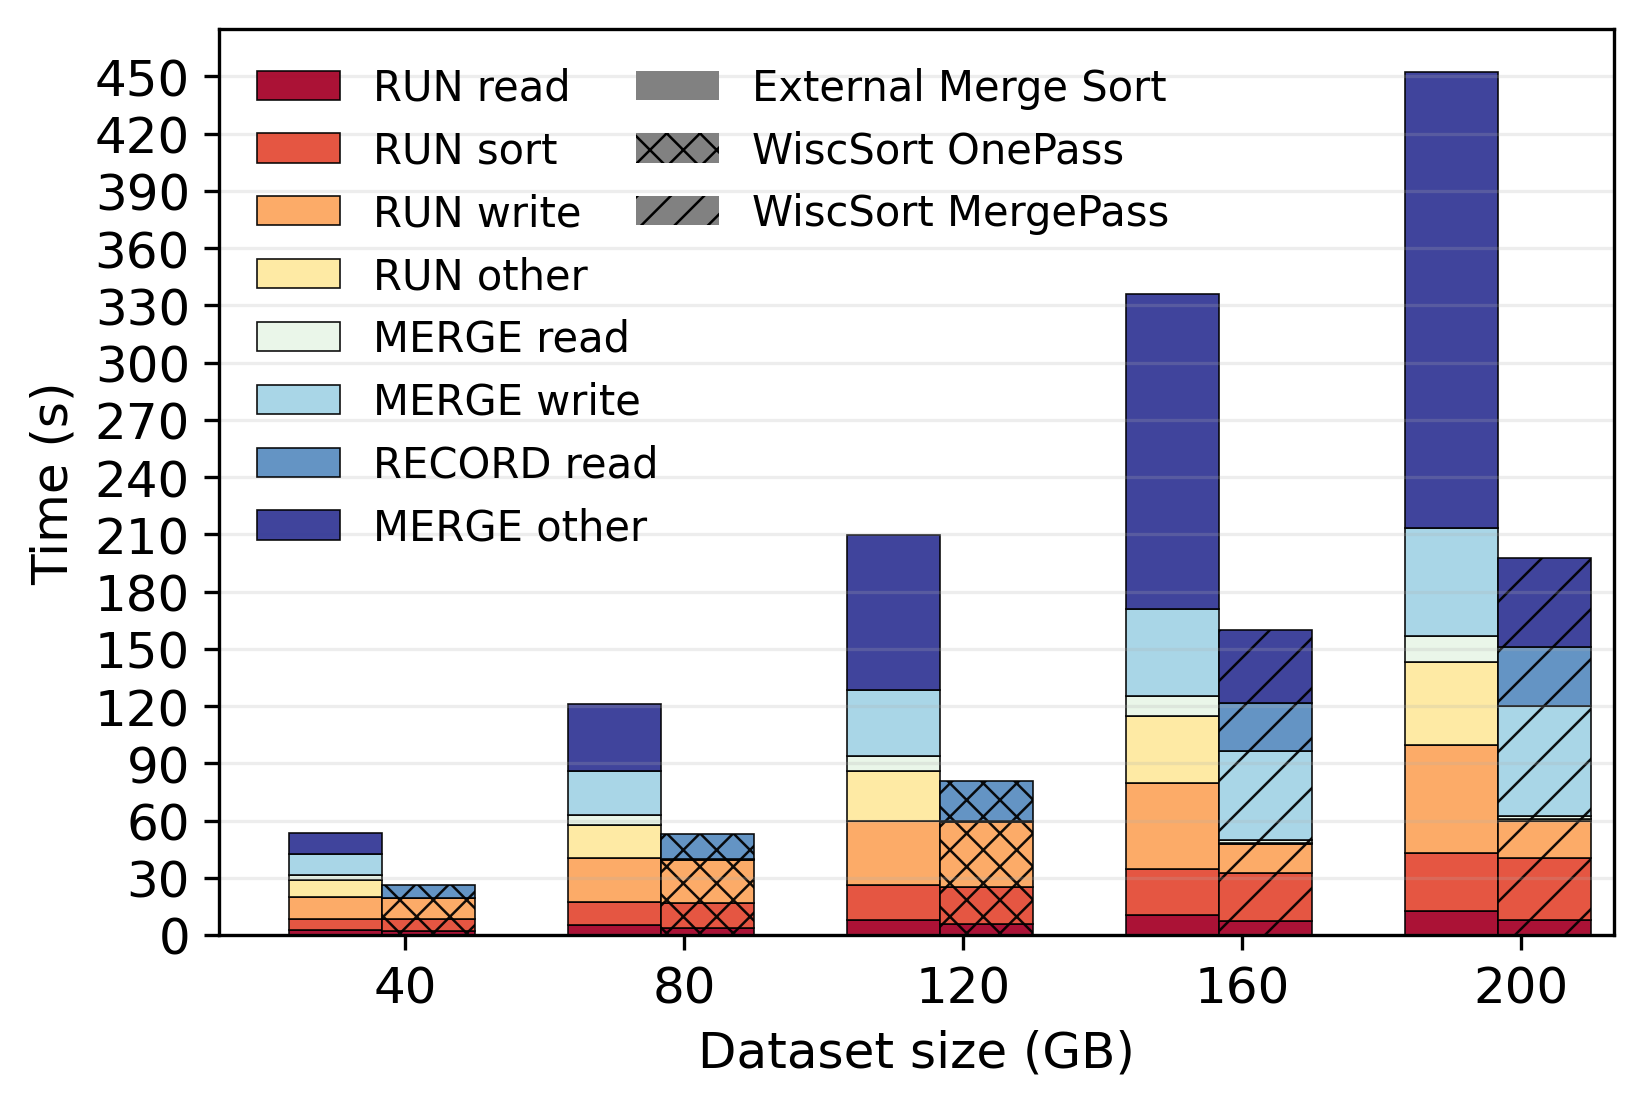

In [51]:
# stacked_bar_runtime('1_second_granularity/5gb_ReadB-5gb_WriteB',['20', '40', '60', '80', '100'],['CEMS', 'WiscSort'])
# stacked_bar_runtime('paper/10RB_5WB',['40', '80', '120', '160', '200'],['CEMS', 'WiscSort', 'WiscSort_merge'])
stacked_bar_runtime('paper/10RB_5WB',['40', '80', '120', '160', '200'],['CEMS', 'WiscSort'])
# stacked_bar_runtime('paper/10RB_5WB',['120', '160'],['CEMS', 'WiscSort'])
# stacked_bar_runtime('paper/10RB_5WB',['40'],['CEMS', 'WiscSort_merge'])

CEMS
        RUN read RUN sort RUN write RUN other MERGE read MERGE write  \
10_246   1.29846  1.22789   5.85708       NaN    1.32079     5.90708   
50_206   1.30923  1.66401   5.83565       NaN    1.32652     6.04061   
100_156  1.29975  2.84572   6.03762       NaN    1.33459     5.92467   
150_106  1.30989  4.04857    5.7504       NaN    1.33604     5.91981   
200_56   1.31167  5.35613   5.85405       NaN    1.33531     6.00287   
250_6    1.32556  6.83481   5.72216       NaN    1.32387     5.78392   

        RECORD read MERGE other Total RUN Total MERGE  
10_246          NaN         NaN   4.46586     4.35322  
50_206          NaN         NaN   5.91253     5.01134  
100_156         NaN         NaN   6.96789     5.29209  
150_106         NaN         NaN   8.04347     5.28821  
200_56          NaN         NaN   8.95532     5.19499  
250_6           NaN         NaN   10.4259      5.0976  
WiscSort
        RUN read RUN sort RUN write RUN other  MERGE read  MERGE write  \
10_246   1.0165

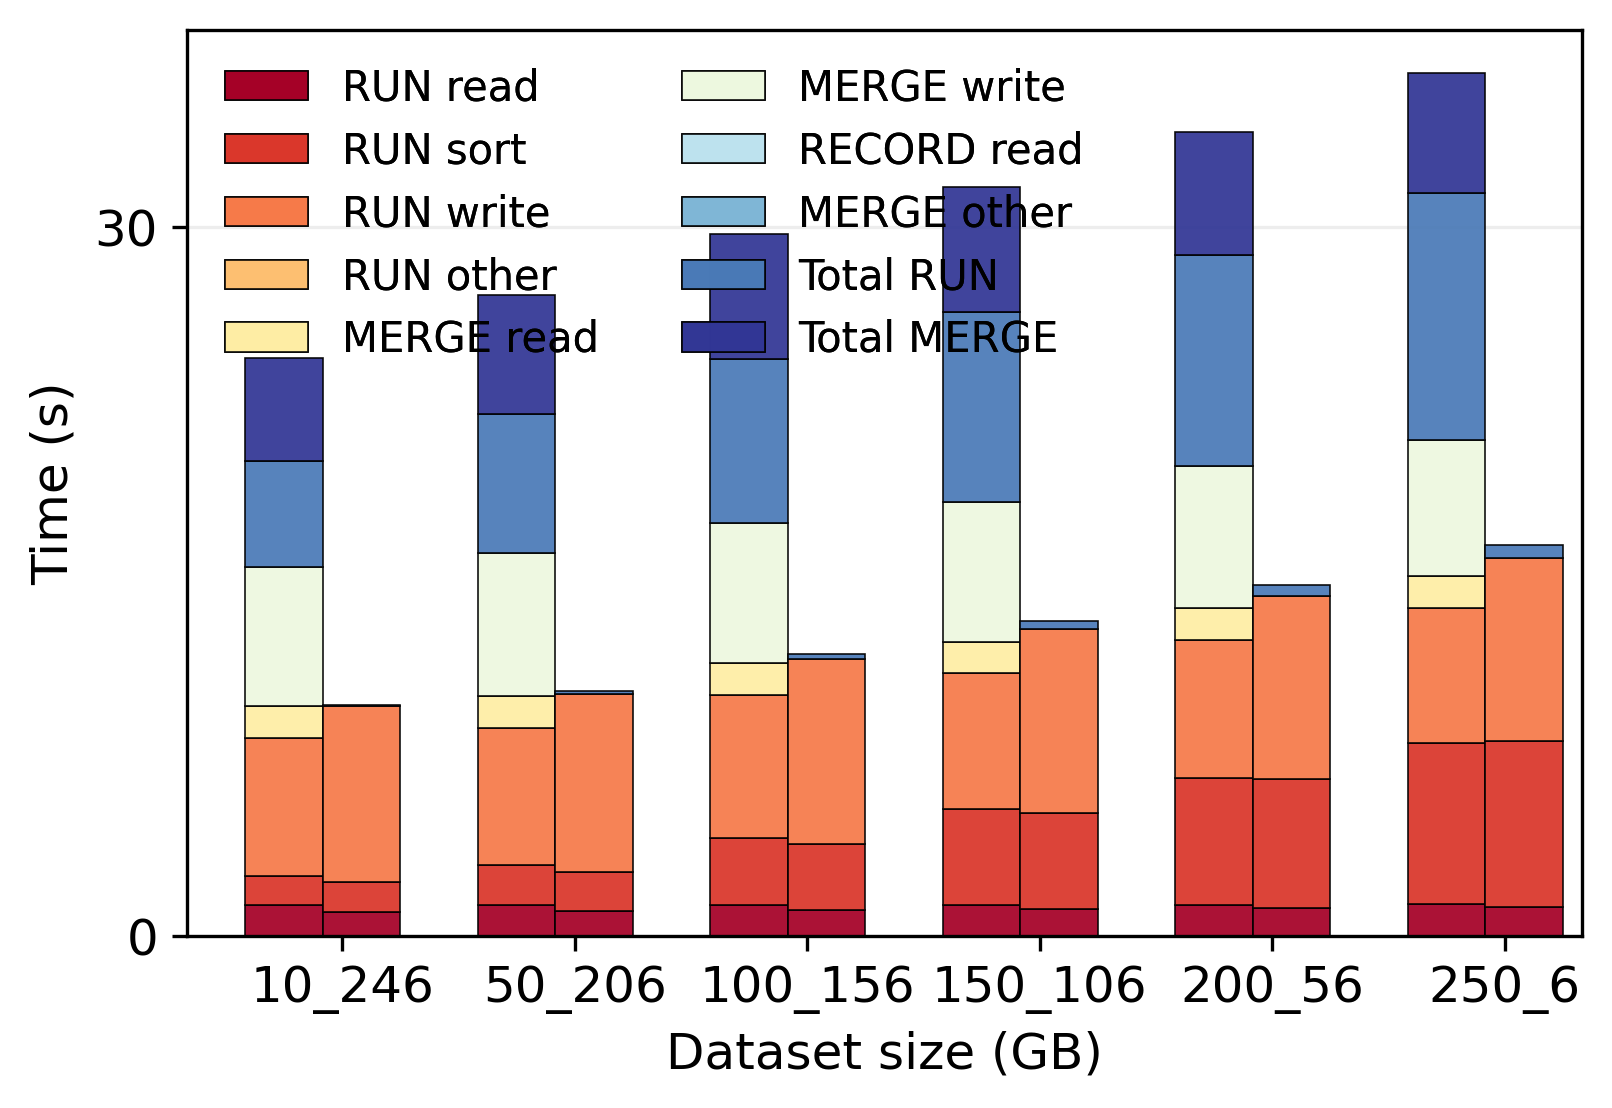

In [1209]:
## This generates with gaps between EMS WSO WSM
plt.rcParams.update({'font.size': 12})

df = pd.DataFrame()
def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="x", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    f = plt.figure(figsize=(6,4))
    axe = f.add_subplot(111)
    # axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      linewidth=0.4,
                      edgecolor='black',
                      alpha = 0.93,
                      **kwargs)  # make bar plots
        #for container in axe.containers:
            #axe.bar_label(container)
    
    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for ind,rect in enumerate(pa.patches): # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                if ind > 2:
                    # rect.set_hatch("//" * int(i*1 / n_col)) #edited part     
                    rect.set_hatch("" * int(i*1 / n_col)) #edited part     
                else:
                    # rect.set_hatch("x" * int(i*3 / n_col)) #edited part     
                    rect.set_hatch("" * int(i*3 / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))
        
    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_title(title)
    #axe.set_xlim(xmax=len(dfall)-1)
    axe.set_axisbelow(True)
    axe.grid(alpha=0.22, axis='y')
    #axe.set_yscale('log')
    #axe.set_yticks(np.arange(0,10^6, 10^2))
    axe.set_yticks(np.arange(0, 500, 30))
    #axe.set_xlabel("Dataset size (GB)")
    axe.set_xlabel("Dataset size (GB)")
    axe.set_ylabel("Time (s)")
    # For num of ops
    #axe.set_yticks(np.arange(0, 2.5e+12, 0.25e+12))
    # For data in TB
    #axe.set_yticks(np.arange(0,250, 25))
    
    # axe.margins(x=0, y=0.05)

    # Add invisible data to add another legend
    n=[]        
    # l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.4])
    l1 = axe.legend(h[:n_col], l[:n_col], loc='upper left', prop={'size': 10}, frameon = False, ncol=2)
    axe.add_artist(l1)
    
    n.append(axe.bar(0, 0, color="gray", hatch=H * 0)) #CEMS
    n.append(axe.bar(0, 0, color="gray", hatch=H * 3)) #OnePass
    n.append(axe.bar(0,0, color="gray", hatch="//" *3)) #MergePass
    
    labels = ['Ext Merge Sort', 'WiscSort OnePass', 'WiscSort MergePass']
    # if labels is not None:
    #     l2 = plt.legend(n, labels, loc='upper center',  bbox_to_anchor=(0.55,1), prop={'size': 10}, frameon = False)

def stacked_bar_runtime(folder,iters, exps):
    send = []
    labels = ['RUN read', 'RUN sort', 'RUN write', 'RUN other', 'MERGE read', 'MERGE write', 'RECORD read', 'MERGE other']
    for ix,exp in enumerate(exps):
        df = pd.DataFrame([], columns = labels)
        for dnum in iters:
            results = pd.read_csv("stats/"+f"{folder}/{dnum}/"+f"{exp}" + "/results", delimiter=r":", header = None)
            begin = 0
            for idx, row in results.iterrows():
                if row[0].startswith("="):
                    begin = idx+1
            results = results[begin:]
            results.index = range(0,len(results))
            for idx, row in results.iterrows():
                results.at[idx,0] = row[0].strip()
            results = results.T
            results.columns = results.loc[0, :].values.tolist()
            ix = exp
            results = results.drop(results.index[0])
            # if exp == exps[(len(exps)-1)]:
            #     results.index = [dnum]
            #     ix = dnum
            results.index = [ix]
            
            if 'Total' in results.columns:
                results = results.drop(columns = ['Total'])
            if 'Total RUN' in results.columns:
                results.at[ix, 'Total RUN'] -= (results.at[ix,'RUN read'] + results.at[ix,'RUN sort'] + results.at[ix,'RUN write'])
            ## adding random read
            if 'RECORD read' in results.columns and 'Total MERGE' not in results.columns:
                results.at[ix, 'Total RUN'] -= results.at[ix, 'RECORD read']
            if 'RECORD read' in results.columns and 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= results.at[ix, 'RECORD read']
            if 'Total MERGE' in results.columns:
                results.at[ix,'Total MERGE'] -= (results.at[ix,'MERGE read'] + results.at[ix,'MERGE write'])
            else:
                results.at[ix,'Total MERGE'] = 0
                results.at[ix,'MERGE read'] = 0
                results.at[ix,'MERGE write'] = 0
            results.index = [dnum]

            # Renaming 'Total' to 'other'
            results = results.rename(columns={'Total RUN':'RUN other', 'Total MERGE': 'MERGE other'})
            
            if (dnum == '160' or dnum == '200') and exp == 'WiscSort':
                for col in results.columns:
                    results[col].values[:] = 0              
            
            if (dnum == '40' or dnum == '80' or dnum == '120') and exp == 'WiscSort_merge':
                for col in results.columns:
                    results[col].values[:] = 0
                                              
            df = pd.concat([df, results])
            # print(df)
        send.append(df)
        # print(exp)
        # print(df)
    plot_clustered_stacked(send, exps, title="", cmap=plt.cm.RdYlBu)
stacked_bar_runtime('1_second_granularity/VKratio',['10_246', '50_206', '100_156', '150_106', '200_56', '250_6'], ['CEMS', 'WiscSort'])

## Vk Ratio graph

['5:10', '10:10', '50:10', '90:10', '246:10', '502:10']
[20.48, 22.4, 40.07, 52.48, 119.74, 238.37]
[12.99, 13.71, 19.88, 26.2, 47.33, 84.27]
[29.27, 27.4, 33.104613, 39.12, 60.02, 97.47]


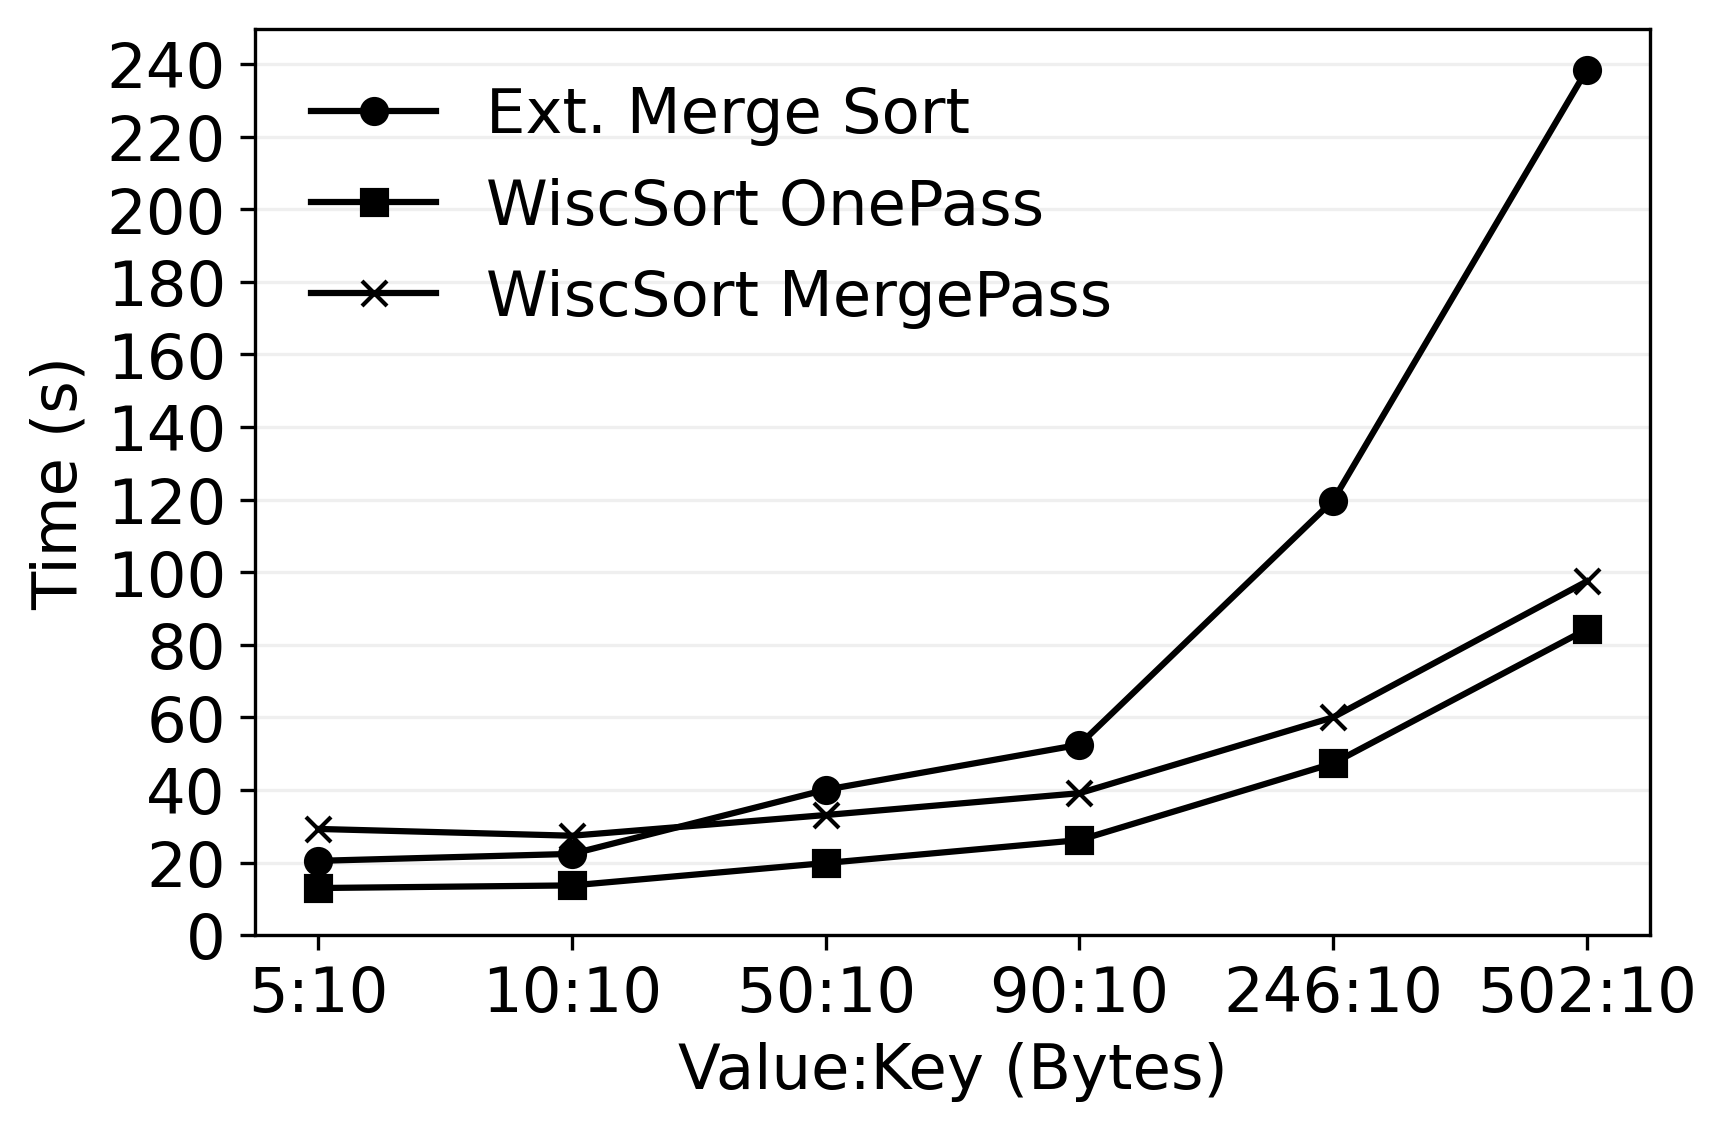

In [1156]:
plt.rcParams.update({'font.size': 15})
cems = [20.48,  22.40, 40.07, 52.48, 119.74, 238.37]
onepass = [12.99, 13.71, 19.88, 26.20, 47.33, 84.27]
mergepass = [29.27, 27.4, 33.104613, 39.12, 60.02 , 97.47]
kv = ['10:5', '10:10', '10:50', '10:90', '10:246', '10:502']
kv = [f"{x.split(':')[1]}:{x.split(':')[0]}" for x in kv]
plt.plot(kv, cems, color='black',  marker='o', label="Ext. Merge Sort", ms = 6)
plt.plot(kv, onepass, color='black',  marker='s', label="WiscSort OnePass", ms = 6)
plt.plot(kv, mergepass, color='black',  marker='x', label="WiscSort MergePass", ms = 6)
plt.legend(frameon = False)
plt.yticks(np.arange(0, 260, step=20))
plt.xlabel("Value:Key (Bytes)")
plt.ylabel("Time (s)")
plt.grid(axis='y', alpha=0.2)
plt.savefig('micro-varying-value.pdf', bbox_inches="tight")
print(kv)
print(cems)
print(onepass)
print(mergepass)

## IndexMap load time 

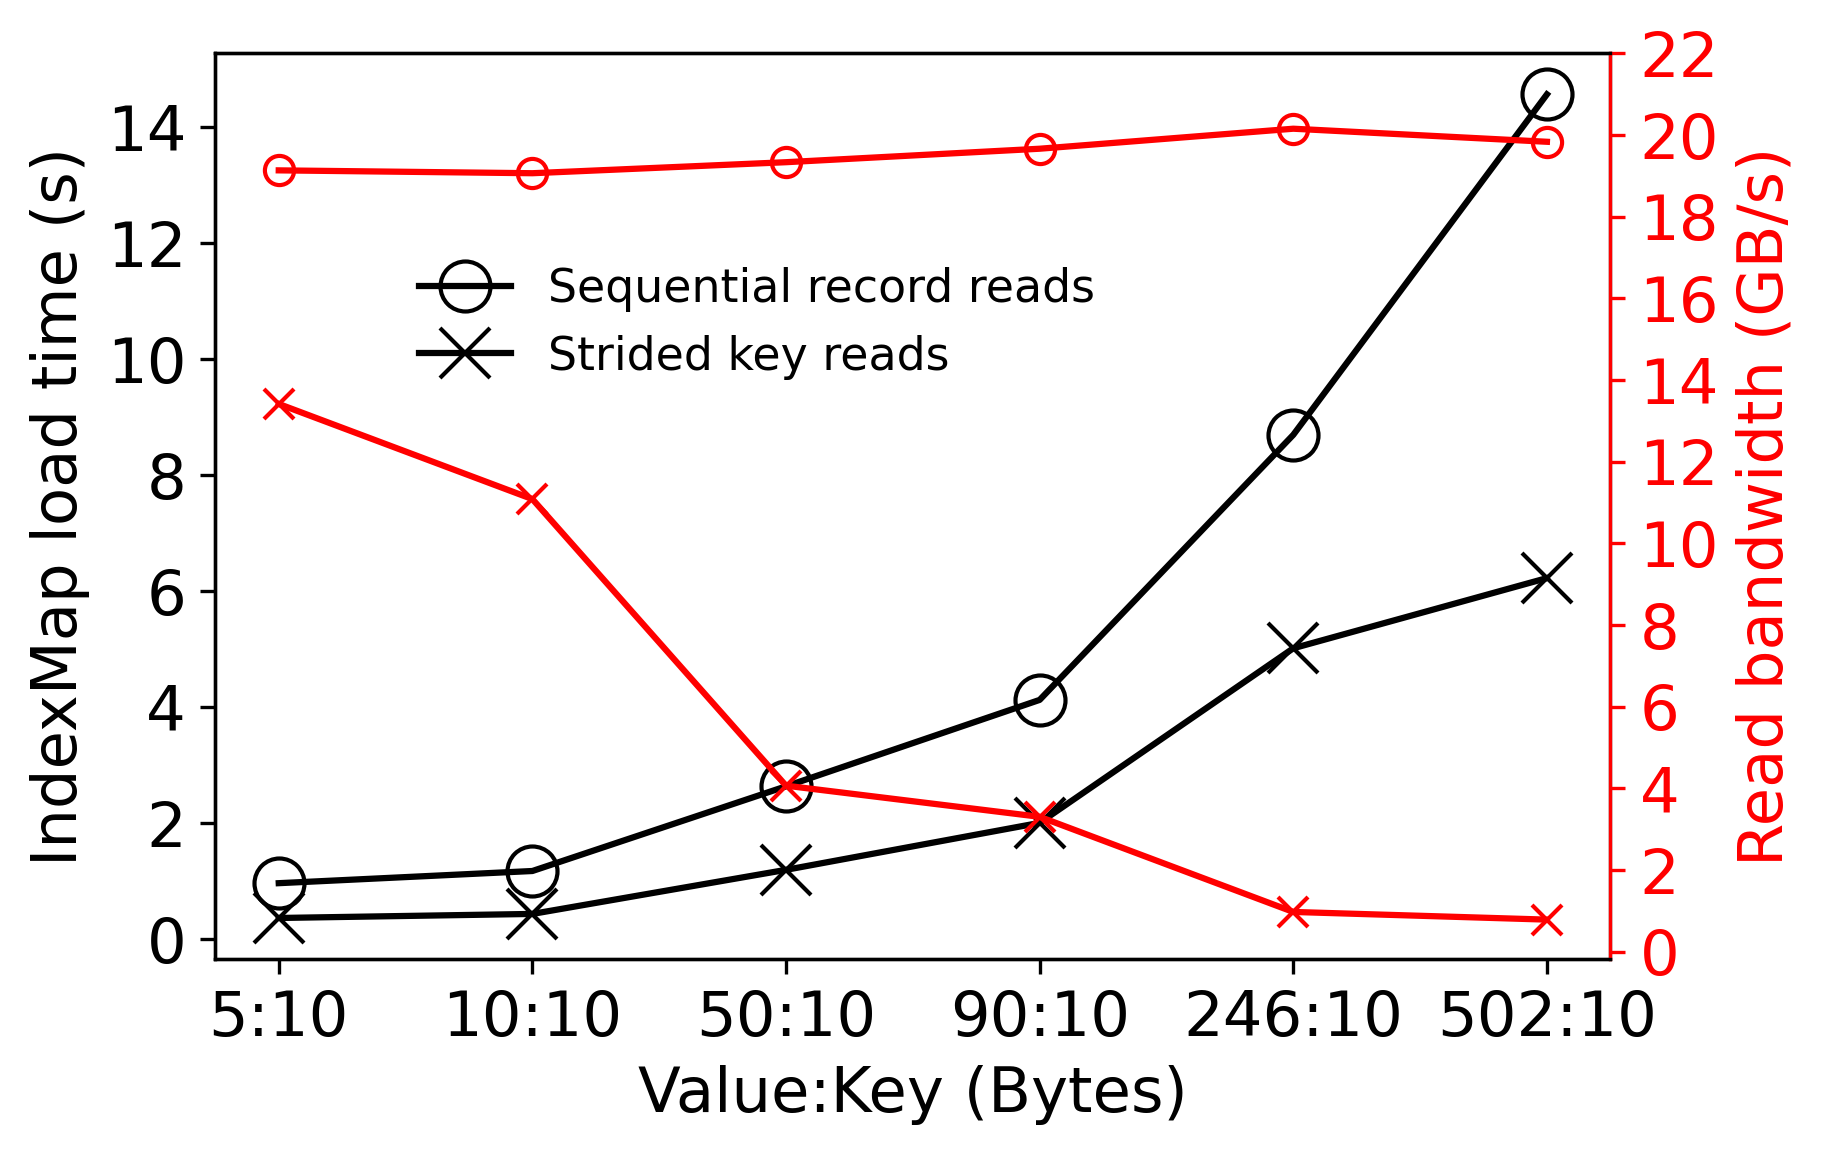

In [1157]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

cems = [0.96, 1.17, 2.63, 4.12, 8.69, 14.56]
split = [0.36, 0.43, 1.19, 2.00, 5.01, 6.22]
kv = ['10:5', '10:10', '10:50', '10:90', '10:246', '10:502']
kv = [f"{x.split(':')[1]}:{x.split(':')[0]}" for x in kv]
ax1.plot(kv, cems, color='black',  marker='o', fillstyle='none', label="Sequential record reads", ms = 12)
ax1.plot(kv, split, color='black', marker='x', label="Strided key reads", ms = 12)
# ax1.legend()
ax1.set_yticks(np.arange(0, 16, step=2))
ax1.set_xlabel("Value:Key (Bytes)")
ax1.set_ylabel("IndexMap load time (s)")

rb_cems = [19.13,19.06,19.33, 19.66, 20.15,19.83]
rb_split = [13.41, 11.08, 4.062, 3.3, 0.97, 0.782]
ax2.plot(kv, rb_cems, color='red', marker='o', fillstyle='none', ms=7)
ax2.plot(kv, rb_split, color='red', marker = 'x', ms=7)
ax2.set_yticks(np.arange(0, 24, step=2))
ax2.spines['right'].set_color('red')
ax2.set_ylabel("Read bandwidth (GB/s)",  color='r')
ax2.tick_params(axis='y', colors='red')
ax1.legend(bbox_to_anchor=(0.66,0.81), prop={'size': 11}, frameon = False)
# plt.grid(axis='y', alpha=0.2)
plt.savefig('micro-strided-seq.pdf', bbox_inches="tight")

## RSW graph

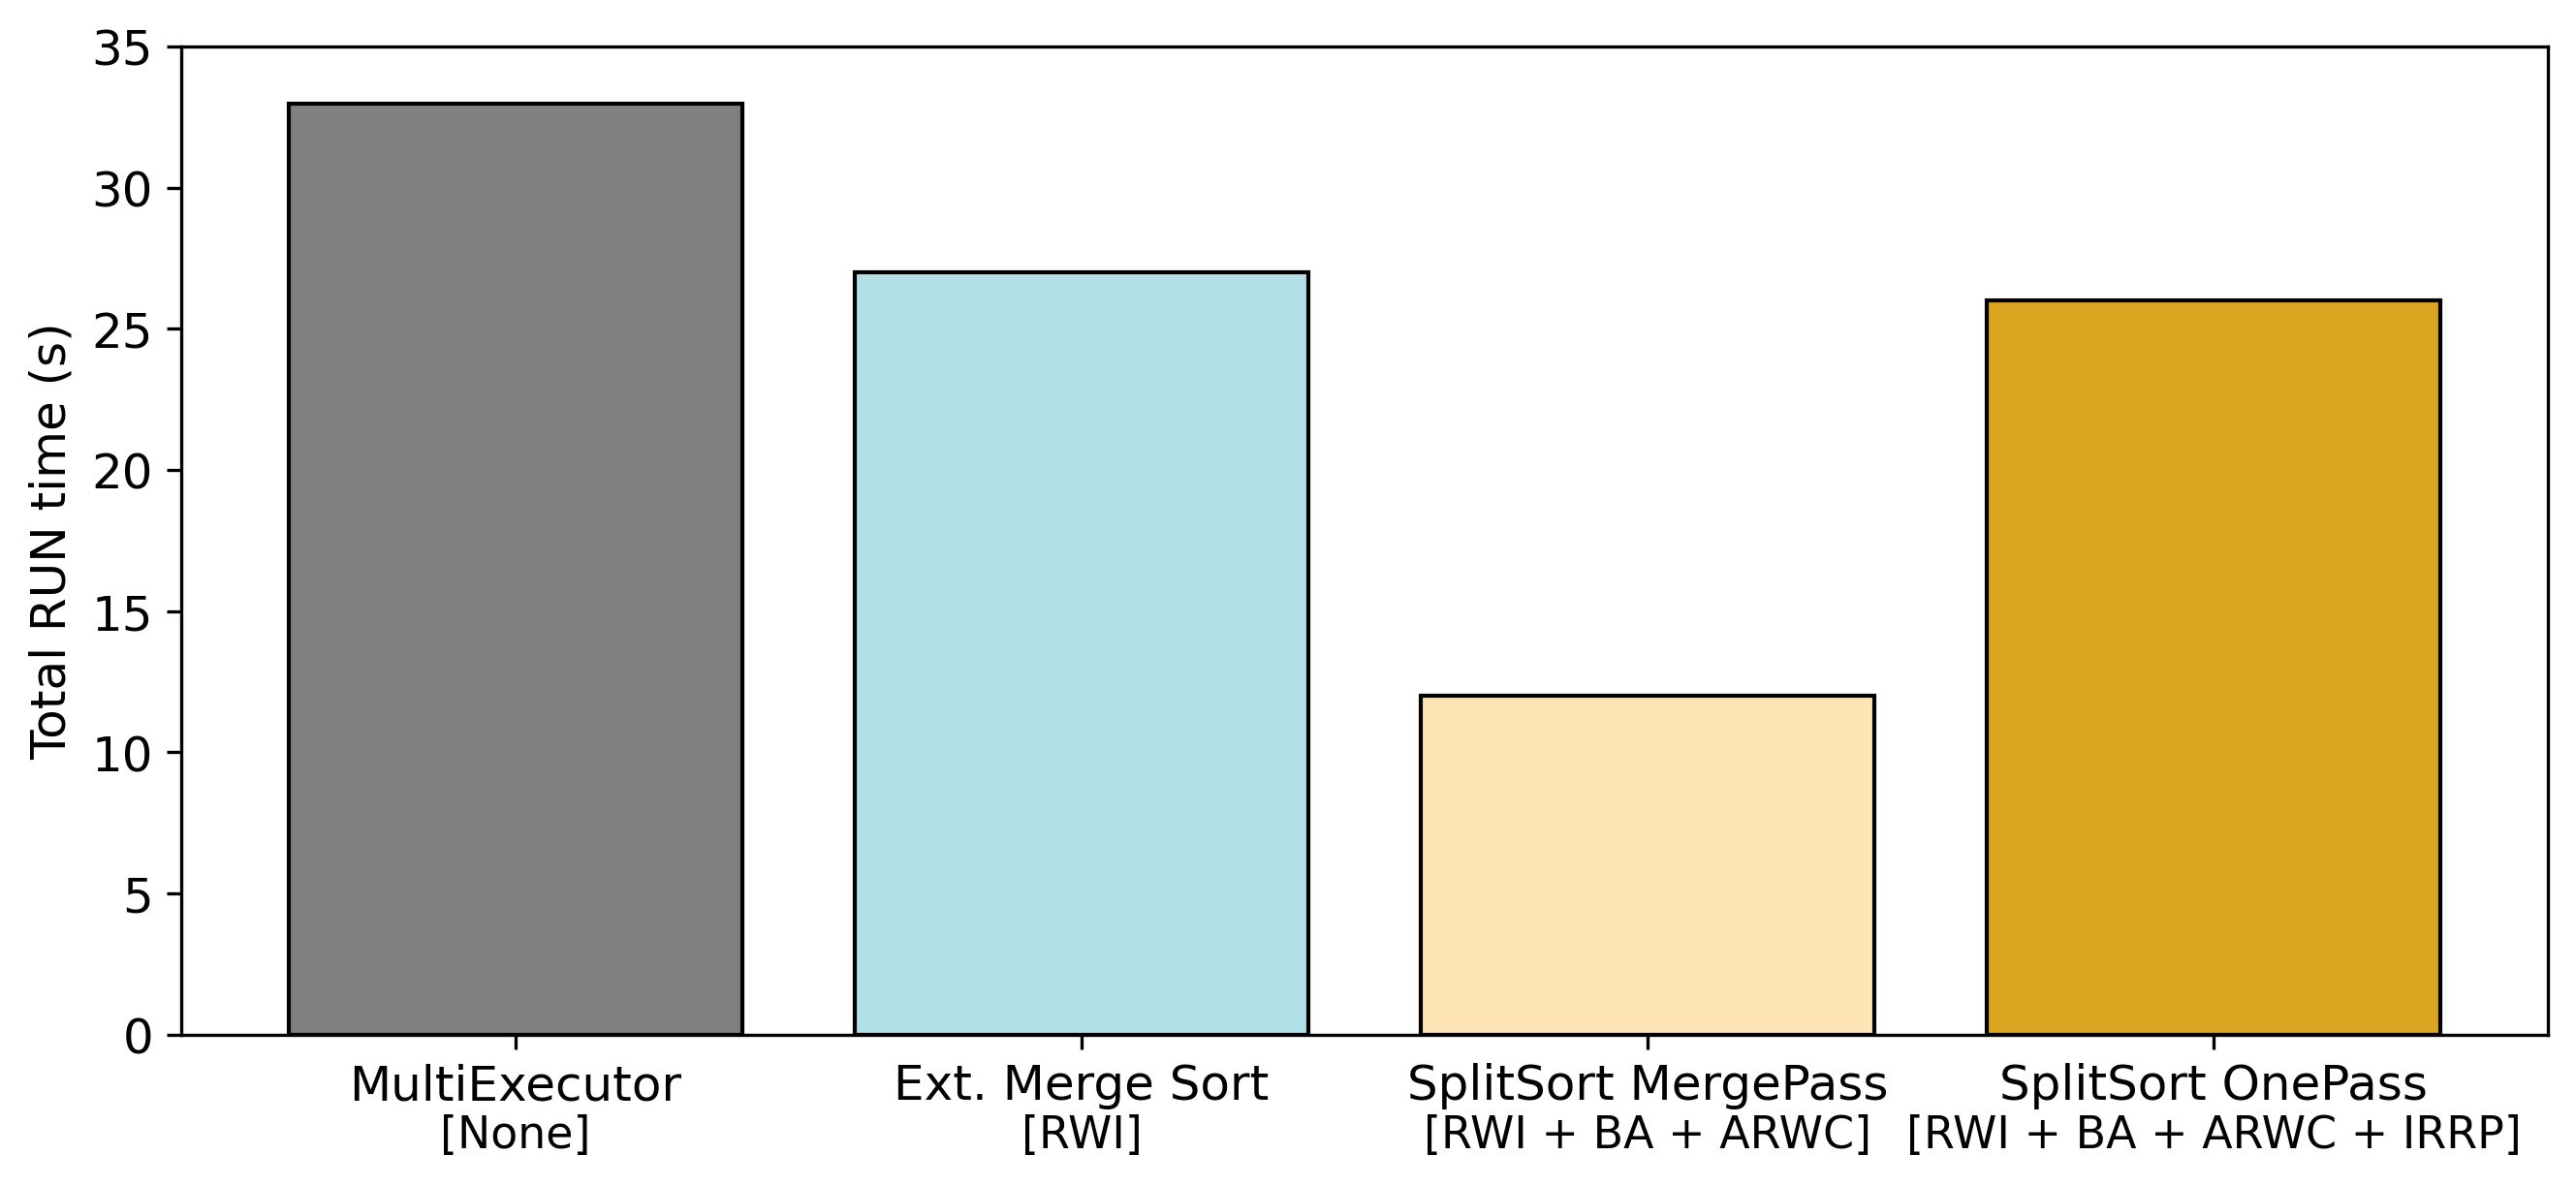

In [426]:
plt.rcParams.update({'font.size': 12})
x = ['MultiExecutor', 'Ext. Merge Sort', 'SplitSort MergePass', 'SplitSort OnePass']
y = [33, 27, 12, 26]
plt.bar(x,y, color=['gray', 'powderblue', 'moccasin', 'goldenrod'], edgecolor='black')
plt.yticks(np.arange(0, 40, step=5))
plt.ylabel("Total RUN time (s)")

plt.text(0,-4, "[None]", 
            size = 11, ha = 'center')
plt.text(1,-4, "[RWI]", 
            size = 11, ha = 'center')
plt.text(2,-4, "[RWI + BA + ARWC]", 
            size = 11, ha = 'center')
plt.text(3,-4, "[RWI + BA + ARWC + IRRP]", 
            size = 11, ha = 'center')
fig = plt.gcf()
fig.set_size_inches(10.5, 4.5)

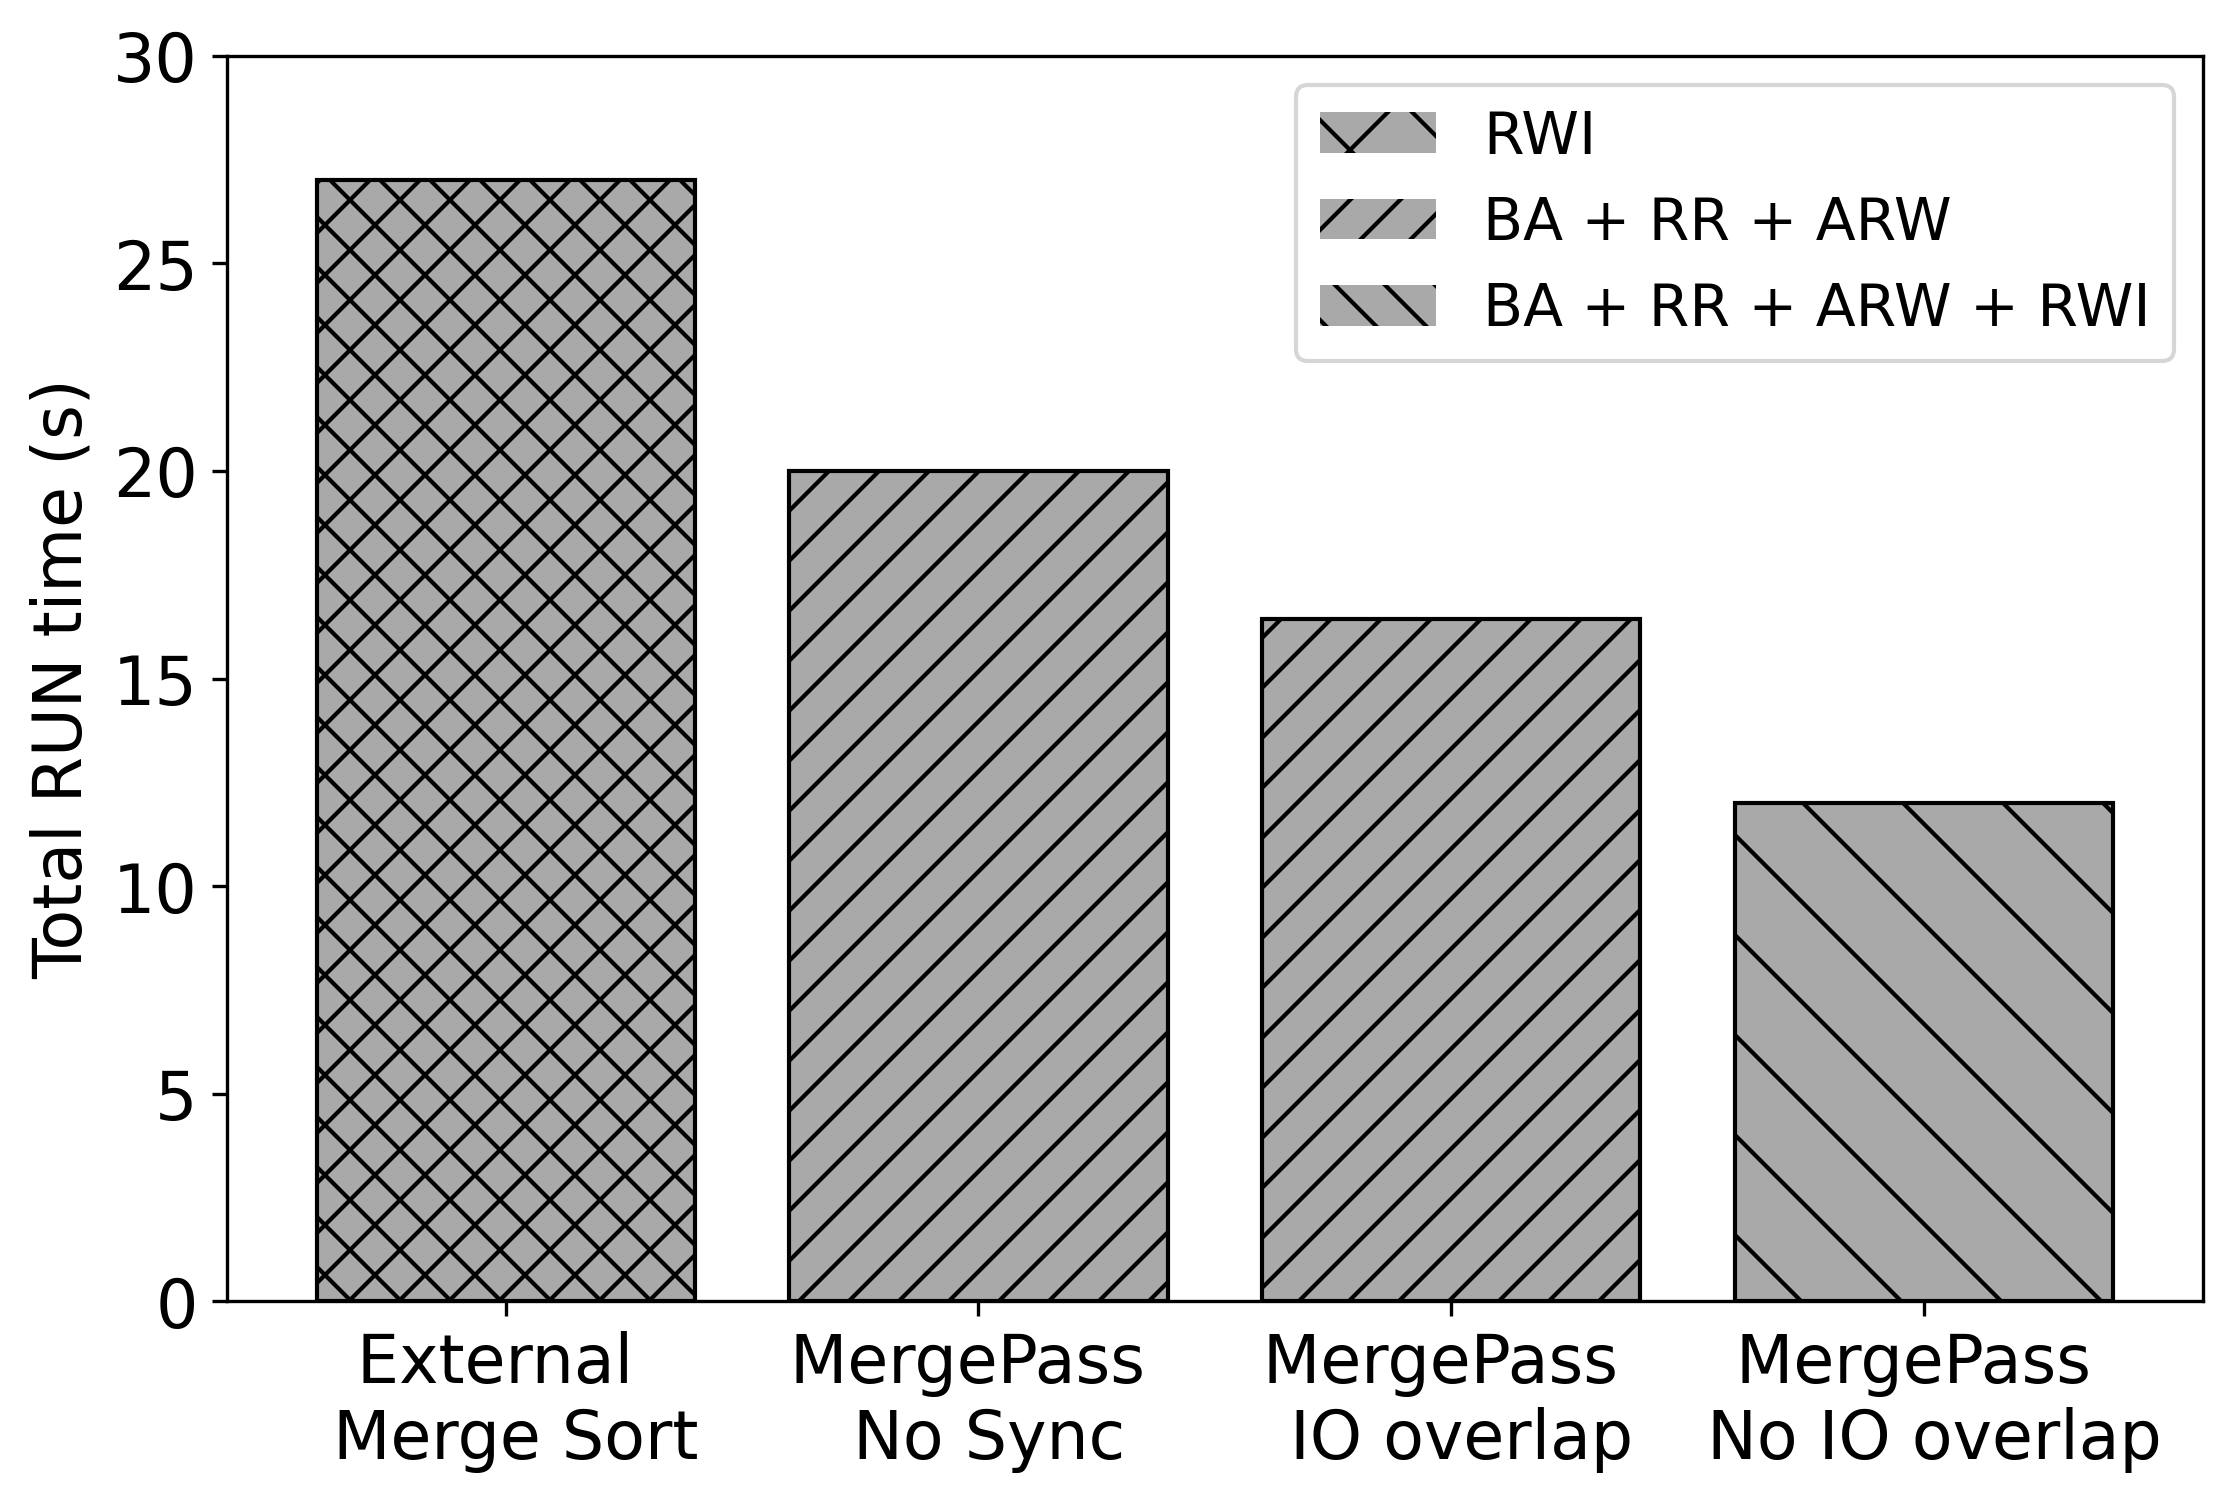

In [565]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure()
x = ['External \n Merge Sort', 'MergePass \n No Sync', 'MergePass \n IO overlap', 'MergePass \n No IO overlap']
y = [27, 20, 16.433, 12]
# patterns = [ "/" , "x", "\\" , "o", "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
patterns = [ "xx" , "//", "//", "\\"]
ax1 = fig.add_subplot(111)
for i in range(len(x)):
        # ax1.bar(x[i], y[i], color="lightgray", edgecolor='black', hatch=patterns[i])
        ax1.bar(x[i], y[i], color="darkgrey", edgecolor='black', hatch=patterns[i])
ax1.set_yticks(np.arange(0, 35, step=5))
ax1.set_ylabel("Total RUN time (s)")
# ax1.set_xticklabels(x, wrap=True)
fig.set_size_inches(8.5, 5.5)

hatches = {'RWI':'x', 'BA + RR + ARW':'//', 'BA + RR + ARW + RWI':'\\\\' } 
labels = ['RWI', 'BA + RR + ARW', 'BA + RR + ARW + RWI']
handles = [plt.Rectangle((7,3),1,1, facecolor='darkgrey', hatch=hatches[label]) for label in labels]
plt.legend(handles, labels, prop={'size': 14})

External 
 Merge Sort 
 No Sync  :  66.41 
 33.6 32.81
External 
 Merge Sort 
 No IO overlap  :  52.81 
 28.0 24.81
PMSort+ 
 No Sync  :  62.71 
 17.1 45.61
PMSort+ 
 IO overlap  :  52.62 
 19.22 33.4
MergePass 
 No Sync  :  59.8 
 14.19 45.61
MergePass 
 IO overlap  :  49.833 
 16.433 33.4
MergePass 
 No IO overlap  :  39.739999999999995 
 12.34 27.4
OnePass 
 No IO overlap  :  26.3 
 26.3 0.0


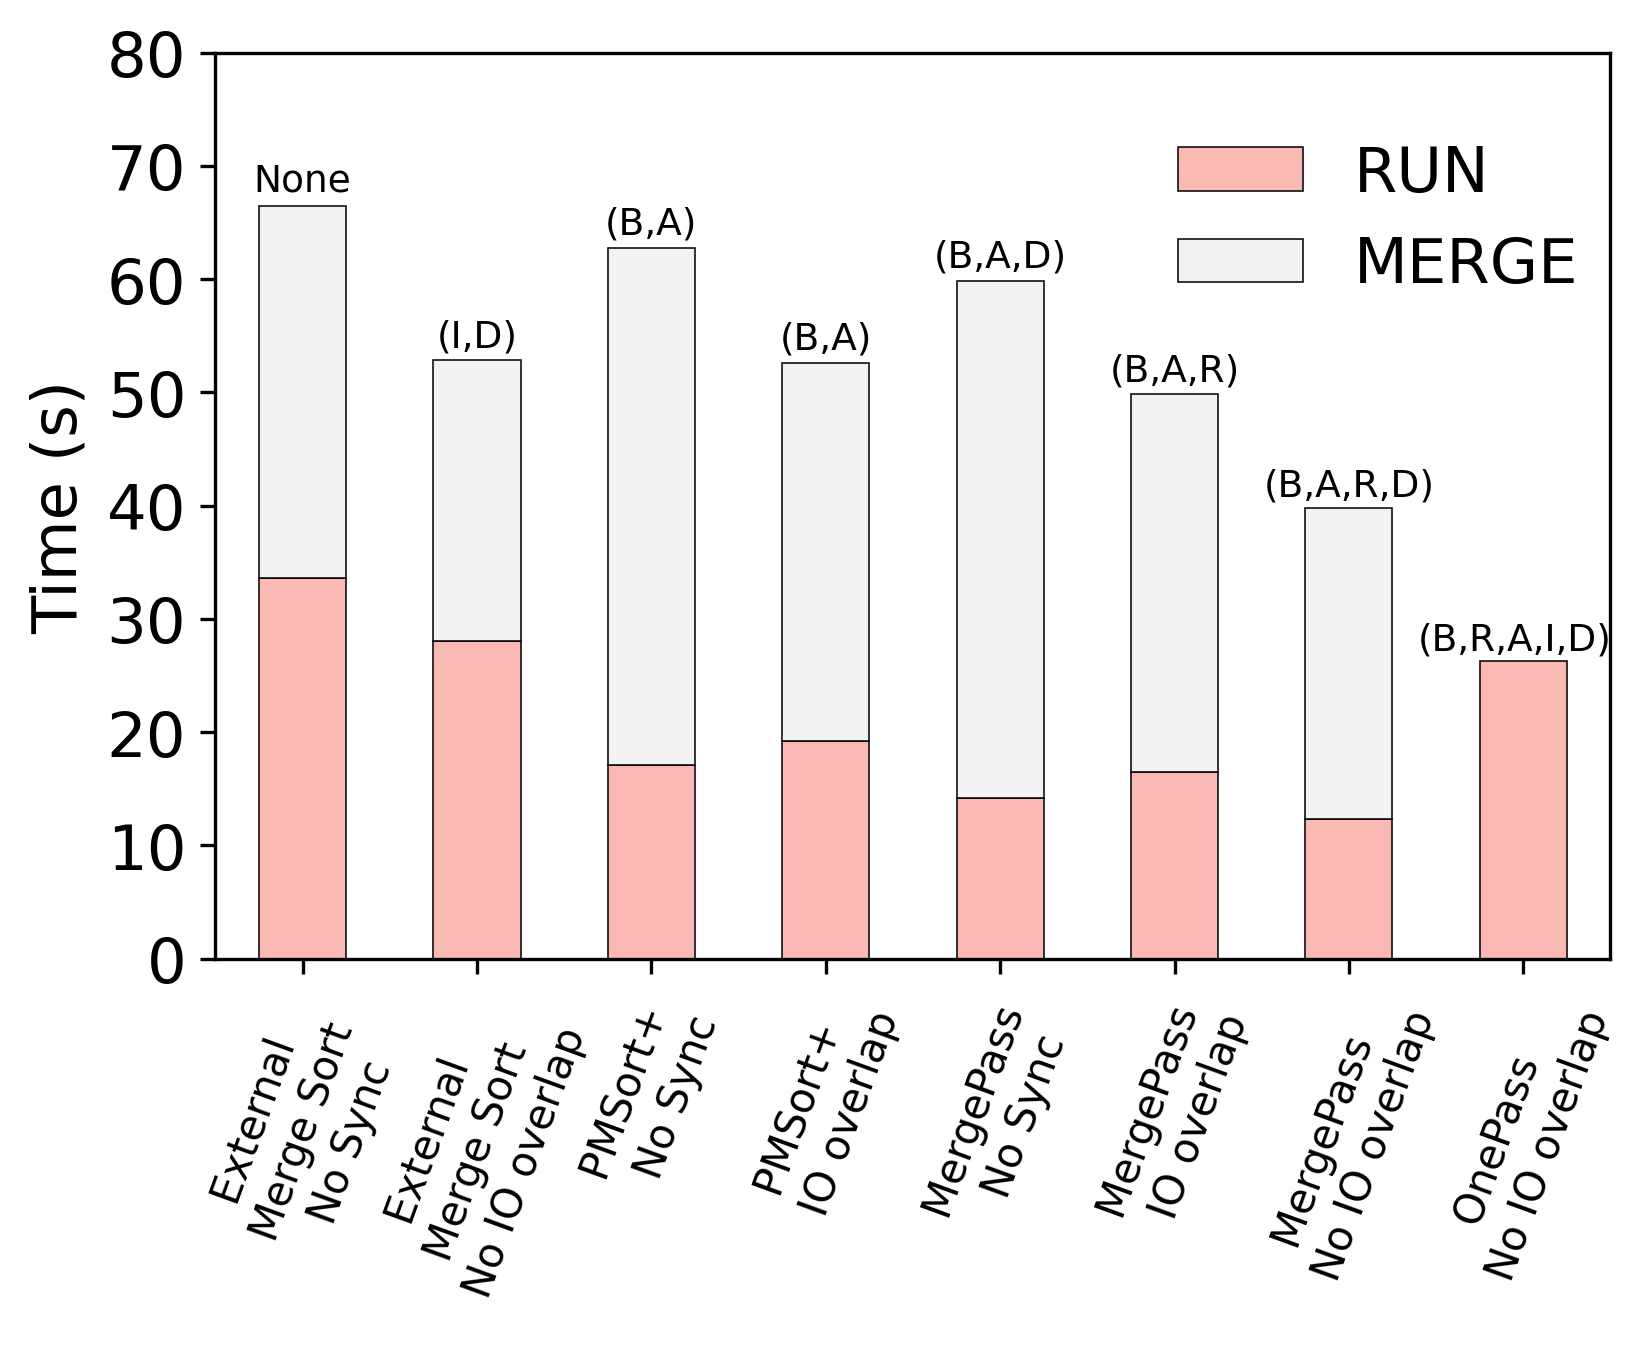

In [66]:
import matplotlib as mpl
import itertools
plt.rcParams.update({'font.size': 15})
## Stacked line graph to show run & merge time.
labels = ['RUN', 'MERGE']
# cm = plt.get_cmap('RdYlBu')
# colors = cm(np.linspace(0, 1, len(labels)))
full_data = {}
run = [33.6, 
       28,
       17.10,
       19.22,       
       14.19,
       16.433,       
       12.34,
       26.3]
merge = [32.81, 
         24.81, 
         45.61, 
         33.4, 
         45.61, 
         33.4, 
         27.4,
         0]
full_data = pd.DataFrame({ 'RUN': run,
                          'MERGE': merge})
full_data['sort'] = ['External \n Merge Sort \n No Sync', 
                     'External \n Merge Sort \n No IO overlap',
                     'PMSort+ \n No Sync',
                     'PMSort+ \n IO overlap',
                     'MergePass \n No Sync', 
                     'MergePass \n IO overlap', 
                     'MergePass \n No IO overlap',
                     'OnePass \n No IO overlap']
full_data.set_index('sort')
# plt.stackplot([exp.split("/")[-1] for exp in exps], [full_data[x] for x in labels], labels=labels, colors=colors)
ax = full_data.plot(x='sort', kind='bar', stacked=True, cmap=plt.cm.Pastel1,                       
                   linewidth=0.4,
                  edgecolor='black',
                  alpha = 0.93,
                  rot = 10)
l1 = ax.legend(["RUN", "MERGE"],  bbox_to_anchor=(0.65,0.67), frameon = False)
# bars = [thing for thing in ax.containers if isinstance(thing,mpl.container.BarContainer)]
# patterns = itertools.cycle(('', 'xx', '', '//', '//', '\\', '','xx', '', '//', '//', '\\'))
# for bar in bars:
#     for patch in bar:
#         patch.set_hatch(next(patterns))
# # L = ax.legend() 
# hatches = {'None': '', '(I + D)':'xx', '(B + A)': '', (B + A + R)':'//', '(B + R + A + I + D)':'\\\\' } 
# labels = ['None', '(I + D)', '(B + A)', '(B + A + R)', '(B + R + A + I + D)']
# handles = [plt.Rectangle((7,3),1,1, facecolor='darkgrey', hatch=hatches[label]) for label in labels]
# plt.legend(handles, labels, prop={'size': 10}, frameon = False)
# plt.gca().add_artist(l1)
# plt.bar(exps, np.array(full_data[labels[2]]))
# plt.grid(axis='x')
# plt.grid(axis='y', alpha=0.1)
plt.ylabel("Time (s)")
plt.xlabel("")
plt.yticks(np.arange(0, 90, step=10))
plt.ylim(0, 80)
plt.xticks(fontsize=10, rotation=70)
# plt.legend(loc='upper right',  bbox_to_anchor=(0.98,1), prop={'size': 9})
# plt.show()
fig = plt.gcf()
fig.set_size_inches(6, 4)

heights = []
for idx,x in full_data.iterrows():
    print(x['sort'], " : ", x['RUN'] + x['MERGE'], '\n', x['RUN'], x['MERGE'])
    heights.append(x['RUN'] + x['MERGE'])

labels = ['None', '(I,D)', '(B,A)', '(B,A)', '(B,A,D)', '(B,A,R)', '(B,A,R,D)',
          '(B,R,A,I,D)', '(B,R,A,I,D)']
patches = ax.patches[len(merge):]
i = 0
for bar in patches:
    height = bar.get_height()
    sub = 0
    if bar == patches[-1]:
        sub = 0.05
    ax.text(bar.get_x() + bar.get_width()/2.-sub, 
            1.01*heights[i],
            '%s' % labels[i],
            ha='center', va='bottom', fontsize=9)
    i+=1
plt.savefig('micro-concur.pdf', bbox_inches="tight")

External 
 Merge Sort 
 No Sync  :  66.41 
 33.6 32.81
External 
 Merge Sort 
 No IO overlap  :  52.81 
 28.0 24.81
MergePass 
 No Sync  :  59.8 
 14.19 45.61
MergePass 
 IO overlap  :  49.833 
 16.433 33.4
MergePass 
 No IO overlap  :  39.739999999999995 
 12.34 27.4


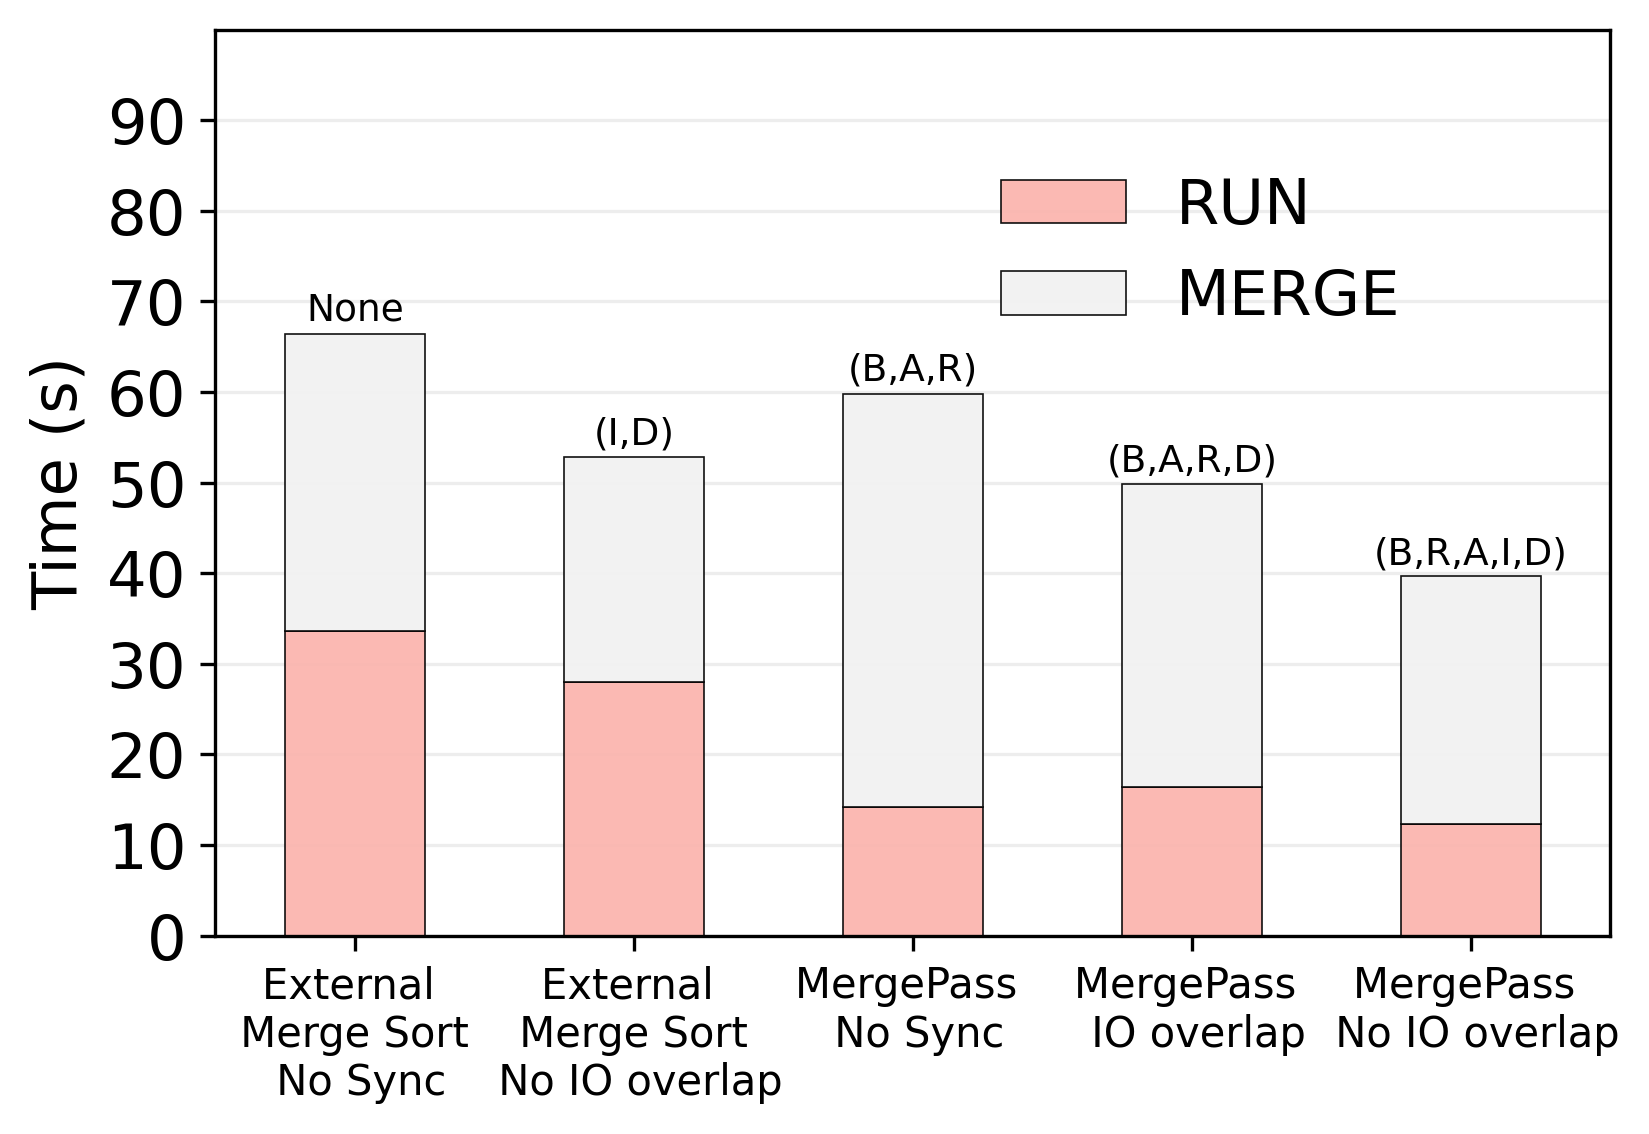

In [59]:
import matplotlib as mpl
import itertools
plt.rcParams.update({'font.size': 15})
## Stacked line graph to show run & merge time.
labels = ['RUN', 'MERGE']
# cm = plt.get_cmap('RdYlBu')
# colors = cm(np.linspace(0, 1, len(labels)))
full_data = {}
run = [33.6, 
       28,       
       14.19,
       16.433,       
       12.34]
merge = [32.81, 
         24.81, 
         45.61, 
         33.4, 
         27.4]
full_data = pd.DataFrame({ 'RUN': run,
                          'MERGE': merge})
full_data['sort'] = ['External \n Merge Sort \n No Sync', 
                     'External \n Merge Sort \n No IO overlap',
                     'MergePass \n No Sync', 
                     'MergePass \n IO overlap', 
                     'MergePass \n No IO overlap']
full_data.set_index('sort')
# plt.stackplot([exp.split("/")[-1] for exp in exps], [full_data[x] for x in labels], labels=labels, colors=colors)
ax = full_data.plot(x='sort', kind='bar', stacked=True, cmap=plt.cm.Pastel1,                       
                   linewidth=0.4,
                  edgecolor='black',
                  alpha = 0.93,
                  rot = 0)
l1 = ax.legend(["RUN", "MERGE"],  bbox_to_anchor=(0.89,0.90), frameon = False)
# bars = [thing for thing in ax.containers if isinstance(thing,mpl.container.BarContainer)]
# patterns = itertools.cycle(('', 'xx', '', '//', '//', '\\', '','xx', '', '//', '//', '\\'))
# for bar in bars:
#     for patch in bar:
#         patch.set_hatch(next(patterns))
# # L = ax.legend() 
# hatches = {'None': '', '(I + D)':'xx', '(B + A)': '', (B + A + R)':'//', '(B + R + A + I + D)':'\\\\' } 
# labels = ['None', '(I + D)', '(B + A)', '(B + A + R)', '(B + R + A + I + D)']
# handles = [plt.Rectangle((7,3),1,1, facecolor='darkgrey', hatch=hatches[label]) for label in labels]
# plt.legend(handles, labels, prop={'size': 10}, frameon = False)
# plt.gca().add_artist(l1)
# plt.bar(exps, np.array(full_data[labels[2]]))
# plt.grid(axis='x')
# plt.grid(axis='y', alpha=0.1)
plt.ylabel("Time (s)")
plt.xlabel("")
plt.yticks(np.arange(0, 100, step=10))
plt.ylim(0, 100)
plt.xticks(fontsize=10)
# plt.legend(loc='upper right',  bbox_to_anchor=(0.98,1), prop={'size': 9})
# plt.show()
fig = plt.gcf()
fig.set_size_inches(6, 4)

heights = []
for idx,x in full_data.iterrows():
    print(x['sort'], " : ", x['RUN'] + x['MERGE'], '\n', x['RUN'], x['MERGE'])
    heights.append(x['RUN'] + x['MERGE'])

labels = ['None', '(I,D)', '(B,A,R)', '(B,A,R,D)',
          '(B,R,A,I,D)']
patches = ax.patches[len(merge):]
ax.set_axisbelow(True)
ax.grid(alpha=0.22, axis='y')
i = 0
for bar in patches:
    height = bar.get_height()
    sub = 0
    ax.text(bar.get_x() + bar.get_width()/2.-sub, 
            1.01*heights[i],
            '%s' % labels[i],
            ha='center', va='bottom', fontsize=9)
    i+=1
plt.savefig('micro-concur.pdf', bbox_inches="tight")